In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [3]:
# Function to calculate RPDE (simplified as standard deviation)
def calculate_rpde(y):
    return np.std(y)

# Function to calculate D2 (simplified using nearest neighbors)
def calculate_d2(y):
    return np.mean([np.sum(np.abs(y[i] - y)) for i in range(len(y))])

# Function to calculate DFA (approximated by Hurst exponent)
def calculate_dfa(y):
    N = len(y)
    T = np.arange(1, N + 1)
    Y = np.cumsum(y - np.mean(y))
    R = np.max(Y) - np.min(Y)
    S = np.std(y)
    hurst_exponent = np.log(R / S) / np.log(N)
    return hurst_exponent

# Function to calculate Spread1, Spread2, and PPE
def calculate_spreads_and_ppe(f0):
    spread1 = np.std(f0)
    spread2 = np.var(f0)
    ppe = -np.sum(f0 * np.log(f0 + 1e-12))
    return spread1, spread2, ppe


# Function to extract features
def extract_features(audio_path, name, recording_number, status):
    y, sr = librosa.load(audio_path, sr=None)

    # Fundamental frequencies
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0 = f0[voiced_flag]  # only use voiced parts
    avg_f0 = np.mean(f0)
    max_f0 = np.max(f0)
    min_f0 = np.min(f0)

    # Jitter and shimmer
    def jitter(f0):
        return np.mean(np.abs(np.diff(f0)) / f0[:-1])

    def shimmer(y):
        S = librosa.feature.rms(y=y)
        return np.mean(np.abs(np.diff(S)) / S[:, :-1])

    jitter_perc = jitter(f0)
    jitter_abs = jitter_perc * avg_f0 / 100
    shimmer_val = shimmer(y)
    shimmer_db = librosa.amplitude_to_db(np.mean(shimmer_val))

    # Noise to harmonic ratio (NHR) and harmonic to noise ratio (HNR)
    harmonic = librosa.effects.harmonic(y)
    nhr = np.sum(np.abs(harmonic - y)) / np.sum(np.abs(y))
    hnr = np.mean(librosa.effects.harmonic(y) / (y - harmonic))

    # RPDE, D2, DFA, spread1, spread2, PPE
    rpde = calculate_rpde(y)
    d2 = calculate_d2(y)
    dfa = calculate_dfa(y)
    spread1, spread2, ppe = calculate_spreads_and_ppe(f0)

    data = {
        'name': f'{name} - {recording_number}',
        'MDVP:Fo(Hz)': avg_f0,
        'MDVP:Fhi(Hz)': max_f0,
        'MDVP:Flo(Hz)': min_f0,
        'MDVP:Jitter(%)': jitter_perc,
        'MDVP:Jitter(Abs)': jitter_abs,
        'MDVP:RAP': jitter_perc,  # Placeholder
        'MDVP:PPQ': jitter_perc,  # Placeholder
        'Jitter:DDP': jitter_perc,  # Placeholder
        'MDVP:Shimmer': shimmer_val,
        'MDVP:Shimmer(dB)': shimmer_db,
        'Shimmer:APQ3': shimmer_val,  # Placeholder
        'Shimmer:APQ5': shimmer_val,  # Placeholder
        'MDVP:APQ': shimmer_val,  # Placeholder
        'Shimmer:DDA': shimmer_val,  # Placeholder
        'NHR': nhr,
        'HNR': hnr,
        'status': status,
        'RPDE': rpde,
        'D2': d2,
        'DFA': dfa,
        'spread1': spread1,
        'spread2': spread2,
        'PPE': ppe
    }

   # Renaming columns for consistency
    rename_mapping = {
        'MDVP:Fo(Hz)': 'avg_fre',
        'MDVP:Fhi(Hz)': 'max_fre',
        'MDVP:Flo(Hz)': 'min_fre',
        'MDVP:Jitter(%)': 'var_fre1',
        'MDVP:Jitter(Abs)': 'var_fre2',
        'MDVP:RAP': 'var_fre3',
        'MDVP:PPQ': 'var_fre4',
        'Jitter:DDP': 'var_fre5',
        'MDVP:Shimmer': 'var_amp1',
        'MDVP:Shimmer(dB)': 'var_amp2',
        'Shimmer:APQ3': 'var_amp3',
        'Shimmer:APQ5': 'var_amp4',
        'MDVP:APQ': 'var_amp5',
        'Shimmer:DDA': 'var_amp6'
    }

    # Renaming the keys in the dictionary
    data = {rename_mapping.get(k, k): v for k, v in data.items()}

    return data

# Function to process all files in a directory
def process_directory(directory, status):
    data = []
    for i, filename in enumerate(tqdm(os.listdir(directory), desc=f'Processing {directory}')):
        if filename.endswith('.wav'):
            filepath = os.path.join(directory, filename)
            subject_name = os.path.splitext(filename)[0]
            features = extract_features(filepath, subject_name, i + 1, status)
            data.append(features)
    return data


# Function to extract the data source from the directory path
def get_data_source(directory_path):
    parts = directory_path.split('/')
    try:
        mydrive_index = parts.index('MyDrive')
        return parts[mydrive_index + 1]
    except ValueError:
        return 'unknown_source'

In [4]:
# Import Kaggle data
df = pd.read_csv("/content/drive/MyDrive/Parkinsson disease.csv")

# Renaming columns for consistency
df.rename(columns={
    'MDVP:Fo(Hz)': 'avg_fre',
    'MDVP:Fhi(Hz)': 'max_fre',
    'MDVP:Flo(Hz)': 'min_fre',
    'MDVP:Jitter(%)': 'var_fre1',
    'MDVP:Jitter(Abs)': 'var_fre2',
    'MDVP:RAP': 'var_fre3',
    'MDVP:PPQ': 'var_fre4',
    'Jitter:DDP': 'var_fre5',
    'MDVP:Shimmer': 'var_amp1',
    'MDVP:Shimmer(dB)': 'var_amp2',
    'Shimmer:APQ3': 'var_amp3',
    'Shimmer:APQ5': 'var_amp4',
    'MDVP:APQ': 'var_amp5',
    'Shimmer:DDA': 'var_amp6'
}, inplace=True)

# Display the Kaggle DataFrame
print(df.head())


             name  avg_fre  max_fre  min_fre  var_fre1  var_fre2  var_fre3  \
0  phon_R01_S01_1  119.992  157.302   74.997   0.00784   0.00007   0.00370   
1  phon_R01_S01_2  122.400  148.650  113.819   0.00968   0.00008   0.00465   
2  phon_R01_S01_3  116.682  131.111  111.555   0.01050   0.00009   0.00544   
3  phon_R01_S01_4  116.676  137.871  111.366   0.00997   0.00009   0.00502   
4  phon_R01_S01_5  116.014  141.781  110.655   0.01284   0.00011   0.00655   

   var_fre4  var_fre5  var_amp1  ...  var_amp6      NHR     HNR  status  \
0   0.00554   0.01109   0.04374  ...   0.06545  0.02211  21.033       1   
1   0.00696   0.01394   0.06134  ...   0.09403  0.01929  19.085       1   
2   0.00781   0.01633   0.05233  ...   0.08270  0.01309  20.651       1   
3   0.00698   0.01505   0.05492  ...   0.08771  0.01353  20.644       1   
4   0.00908   0.01966   0.06425  ...   0.10470  0.01767  19.649       1   

       RPDE       DFA   spread1   spread2        D2       PPE  
0  0.414783  0.8

In [5]:
df["status"].value_counts()

status
1    147
0     48
Name: count, dtype: int64

In [6]:
# Remove the suffix after the last underscore in the 'name' column
df['name'] = df['name'].str.replace(r'_\d+$', '', regex=True)

In [7]:
# Get the number of unique values in the 'name' column
unique_names_count = df['name'].nunique()
print(f"Number of unique values in 'name': {unique_names_count}")

Number of unique values in 'name': 32


In [8]:
df.shape

(195, 24)

In [9]:
df.describe()

,avg_fre,max_fre,min_fre,var_fre1,var_fre2,var_fre3,var_fre4,var_fre5,var_amp1,var_amp2,...,var_amp6,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [10]:
df.duplicated().sum()

0

In [11]:
df.isnull().sum()

name        0
avg_fre     0
max_fre     0
min_fre     0
var_fre1    0
var_fre2    0
var_fre3    0
var_fre4    0
var_fre5    0
var_amp1    0
var_amp2    0
var_amp3    0
var_amp4    0
var_amp5    0
var_amp6    0
NHR         0
HNR         0
status      0
RPDE        0
DFA         0
spread1     0
spread2     0
D2          0
PPE         0
dtype: int64

In [12]:
df.iloc[:, 1:].skew()

avg_fre     0.591737
max_fre     2.542146
min_fre     1.217350
var_fre1    3.084946
var_fre2    2.649071
var_fre3    3.360708
var_fre4    3.073892
var_fre5    3.362058
var_amp1    1.666480
var_amp2    1.999389
var_amp3    1.580576
var_amp4    1.798697
var_amp5    2.618047
var_amp6    1.580618
NHR         4.220709
HNR        -0.514317
status     -1.187727
RPDE       -0.143402
DFA        -0.033214
spread1     0.432139
spread2     0.144430
D2          0.430384
PPE         0.797491
dtype: float64

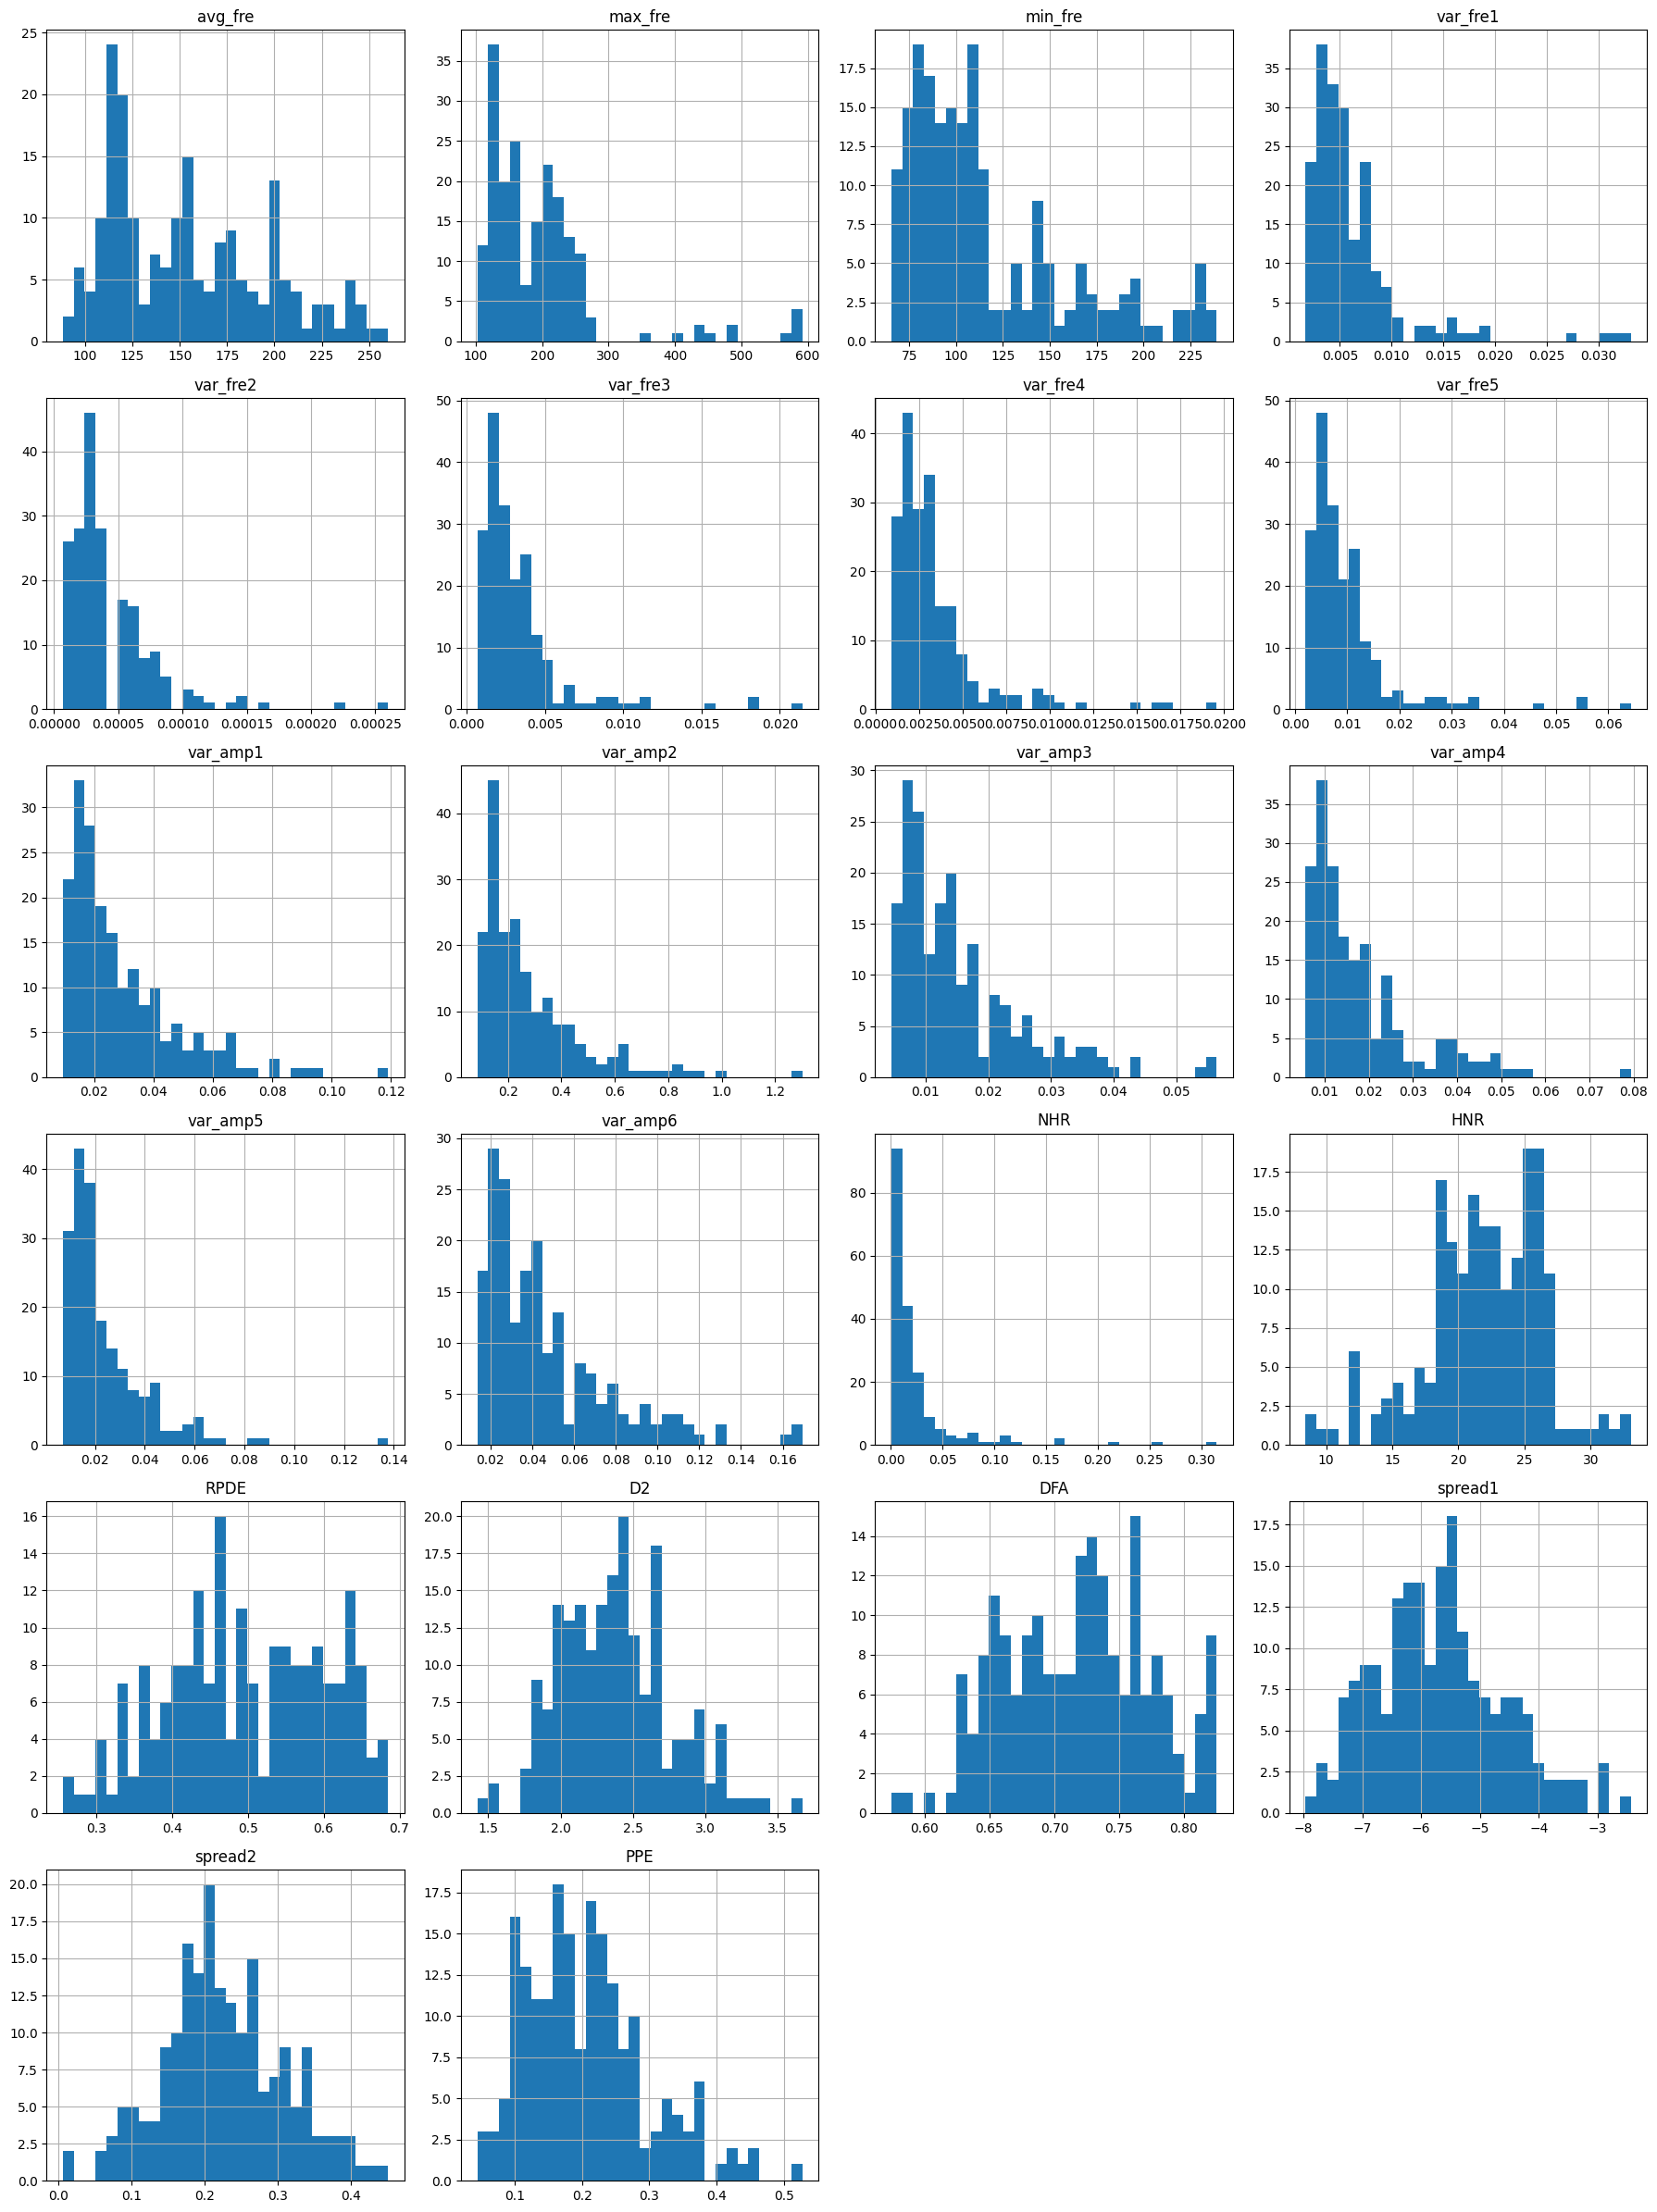

In [13]:
import matplotlib.pyplot as plt
# Histograms
selected_columns =  ['avg_fre', 'max_fre', 'min_fre', 'var_fre1', 'var_fre2', 'var_fre3', 'var_fre4', 'var_fre5',
'var_amp1', 'var_amp2', 'var_amp3', 'var_amp4', 'var_amp5', 'var_amp6', 'NHR', 'HNR', 'RPDE', 'D2', 'DFA', 'spread1', 'spread2', 'PPE']
num_features = len(selected_columns)
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))

plt.figure(figsize=(18, num_rows * 4))

for i, column in enumerate(selected_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    df[column].hist(bins=30)
    plt.title(column)
    plt.tight_layout()

plt.savefig("/content/drive/MyDrive/Kaggle Feature Histogram.png")
plt.show()

In [14]:
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import VarianceThreshold

# Function for Z-score filtering
def z_score_filter(df, threshold=3):
    z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
    return df[(z_scores < threshold).all(axis=1)]

# Function for Isolation Forest filtering
def isolation_forest_filter(df, contamination=0.1):
    iso = IsolationForest(contamination=contamination, random_state=42)
    preds = iso.fit_predict(df.select_dtypes(include=[np.number]))
    mask = preds != -1  # -1 indicates outliers
    return df[mask]

# Function for Variance Threshold filtering
def variance_threshold_filter(df, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    features = df.select_dtypes(include=[np.number])
    selected_features = selector.fit_transform(features)
    return df[features.columns[selector.get_support(indices=True)]]

In [15]:
# Function to filter and scale the DataFrame
def filter_and_scale_df(df):
    # Apply filtering criteria
    # df = df[df['avg_fre'] <= ]
    df = df[df['max_fre'] <= 300]
    # df = df[df['min_fre'] <= ]
    df = df[df['var_fre1'] <= 0.02]
    df=df[df.var_fre2<=0.0001]
    df=df[df.var_fre3<=0.01]
    df=df[df.var_fre4<=0.01]
    df=df[df.var_fre5<=0.02]
    df = df[df['var_amp1'] <= 0.10]
    df=df[df.var_amp2<=1.0]
    df=df[df.var_amp3<=0.04]
    df=df[df.var_amp4<=0.050]
    df=df[df.var_amp5<=0.075]
    df=df[df.var_amp6<=0.125]
    df = df[df['NHR'] <= 0.06]
    # df = df[df['HNR'] <= ]
    # df = df[df['RPDE'] <= ]
    # df = df[df['D2'] <= ]
    # df = df[df['DFA'] <= ]
    # df = df[df['spread1'] <= ]
    # df = df[df['spread2'] <= ]
    # df = df[df['PPE'] <= 1]

    # Apply filtering steps
    #df = z_score_filter(df, threshold=2)
    #df = isolation_forest_filter(df, contamination=0.1)
    #df = variance_threshold_filter(df, threshold=0.01)

    # Keep only the necessary features
    selected_columns =  ['avg_fre', 'max_fre', 'min_fre', 'var_fre1', 'var_amp1','NHR', 'HNR', 'RPDE', 'D2', 'DFA', 'spread1', 'spread2', 'PPE']
    features = df[selected_columns].values
    labels = df['status'].values

    # Scale the features to between -1 and 1
    scaler = MinMaxScaler((-1, 1))
    scaled_features = scaler.fit_transform(features)

    return df, scaled_features, labels

# Preprocess Kaggle data
df, x, y = filter_and_scale_df(df)

# Display the filtered and scaled DataFrames
print(df.head())


           name  avg_fre  max_fre  min_fre  var_fre1  var_fre2  var_fre3  \
0  phon_R01_S01  119.992  157.302   74.997   0.00784   0.00007   0.00370   
1  phon_R01_S01  122.400  148.650  113.819   0.00968   0.00008   0.00465   
2  phon_R01_S01  116.682  131.111  111.555   0.01050   0.00009   0.00544   
3  phon_R01_S01  116.676  137.871  111.366   0.00997   0.00009   0.00502   
5  phon_R01_S01  120.552  131.162  113.787   0.00968   0.00008   0.00463   

   var_fre4  var_fre5  var_amp1  ...  var_amp6      NHR     HNR  status  \
0   0.00554   0.01109   0.04374  ...   0.06545  0.02211  21.033       1   
1   0.00696   0.01394   0.06134  ...   0.09403  0.01929  19.085       1   
2   0.00781   0.01633   0.05233  ...   0.08270  0.01309  20.651       1   
3   0.00698   0.01505   0.05492  ...   0.08771  0.01353  20.644       1   
5   0.00750   0.01388   0.04701  ...   0.06985  0.01222  21.378       1   

       RPDE       DFA   spread1   spread2        D2       PPE  
0  0.414783  0.815285 -4.813

In [16]:
df.iloc[:, 1:].skew()

avg_fre     0.629564
max_fre     0.328258
min_fre     1.245583
var_fre1    0.699469
var_fre2    0.769365
var_fre3    0.813203
var_fre4    1.212263
var_fre5    0.812495
var_amp1    1.063387
var_amp2    1.136743
var_amp3    1.116058
var_amp4    1.381370
var_amp5    1.098219
var_amp6    1.115979
NHR         1.327245
HNR         0.174386
status     -1.064996
RPDE       -0.061493
DFA        -0.133070
spread1     0.298066
spread2     0.123992
D2          0.194425
PPE         0.553609
dtype: float64

In [17]:
df.shape

(165, 24)

In [31]:
df["status"].value_counts()

status
1    121
0     44
Name: count, dtype: int64

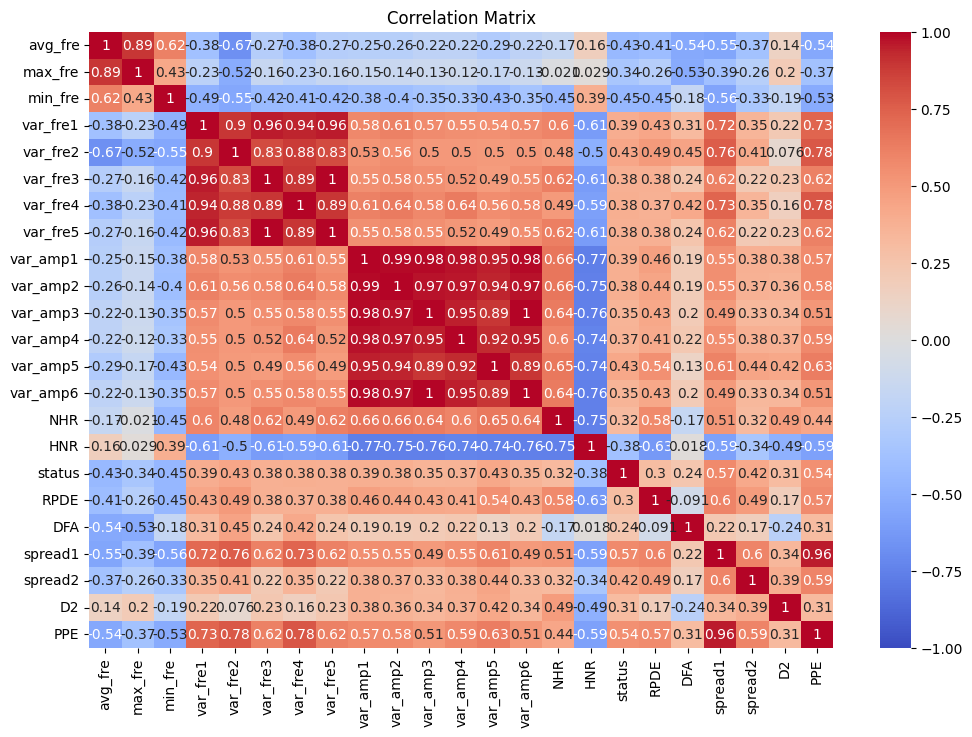

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.iloc[:, 1:].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')

plt.savefig("/content/drive/MyDrive/Kaggle Correlation Matrix Bef.png")
plt.show()

In [22]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate VIF for each feature in the dataframe
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# Assuming df is your original dataframe with all features
# Drop the first column if it's not a feature column
df_features = df.iloc[:, 1:]

# Calculate VIF for the features
vif_df = calculate_vif(df_features)

# Sort the VIF values in descending order
vif_df_sorted = vif_df.sort_values(by="VIF", ascending=False)

# Print the VIF values for all features
print("VIF values for all features:")
print(vif_df_sorted)

VIF values for all features:
     feature           VIF
10  var_amp3  3.679256e+07
13  var_amp6  3.675155e+07
5   var_fre3  1.381342e+06
7   var_fre5  1.381072e+06
8   var_amp1  3.594255e+03
18       DFA  4.547754e+02
19   spread1  4.175932e+02
9   var_amp2  3.785317e+02
3   var_fre1  3.722360e+02
11  var_amp4  3.355920e+02
12  var_amp5  3.280273e+02
6   var_fre4  2.918487e+02
0    avg_fre  2.135925e+02
15       HNR  1.692164e+02
22       PPE  1.300739e+02
21        D2  1.179399e+02
1    max_fre  1.077569e+02
4   var_fre2  9.561687e+01
17      RPDE  7.171279e+01
2    min_fre  2.137420e+01
20   spread2  2.132913e+01
14       NHR  1.100961e+01
16    status  7.176891e+00


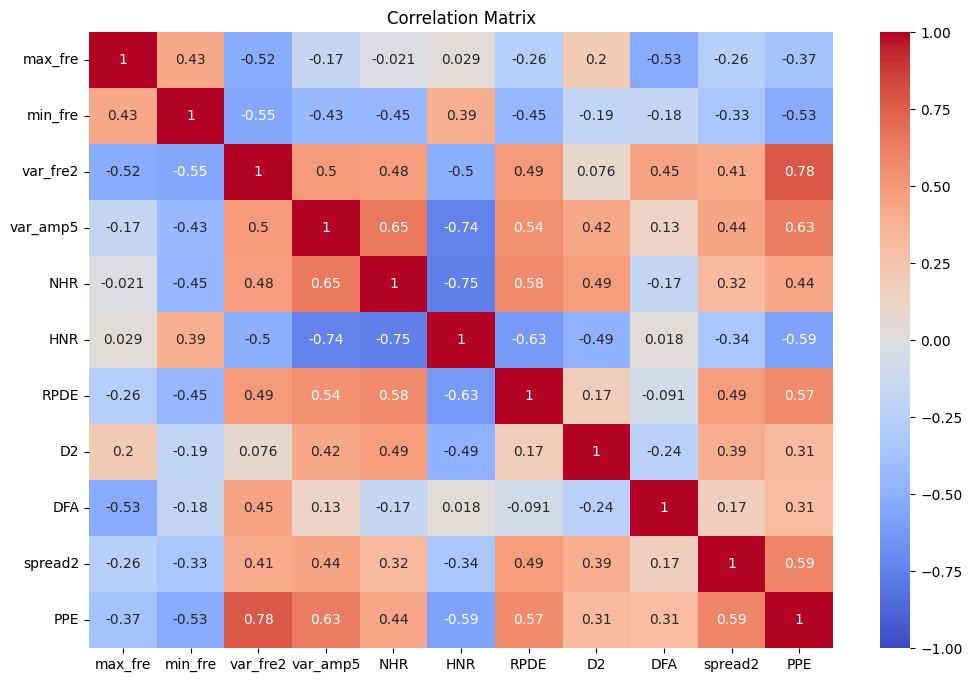

In [23]:
# Correlation matrix
import matplotlib.pyplot as plt
selected_columns =  ['max_fre', 'min_fre', 'var_fre2', 'var_amp5','NHR', 'HNR', 'RPDE', 'D2', 'DFA','spread2','PPE']
plt.figure(figsize=(12, 8))
correlation_matrix = df[selected_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')

plt.savefig("/content/drive/MyDrive/Kaggle Correlation Matrix Aft.png")
plt.show()

In [18]:
# Function to filter and scale the DataFrame
def feature_select_df(df):

    # Keep only the necessary features
    selected_columns =  ['max_fre', 'min_fre', 'var_fre2', 'var_amp5','NHR', 'HNR', 'RPDE', 'D2', 'DFA','spread2','PPE']
    features = df[selected_columns].values
    labels = df['status'].values

    # Scale the features to between -1 and 1
    scaler = MinMaxScaler((-1, 1))
    scaled_features = scaler.fit_transform(features)

    return df, scaled_features, labels

# Preprocess Kaggle data
df, x, y = feature_select_df(df)

In [24]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Split the Kaggle data into training and testing sets
# xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.5, random_state=42)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Combine features, labels, and names into a single DataFrame
df_combined = df[['name']].copy()
df_combined[selected_columns] = x
df_combined['status'] = y

# Group by 'name'
grouped = df_combined.groupby('name')

# Convert groups to a list and shuffle with a fixed random state
groups = list(grouped)
random_state = 42
np.random.seed(random_state)  # Set the seed for reproducibility
np.random.shuffle(groups)

# Split groups into training and testing sets
train_groups = []
test_groups = []
train_size = 0
test_size = 0

# Iterate through the shuffled groups and assign them to train or test set
for group_name, group_data in groups:
    if train_size <= test_size:
        train_groups.append(group_data)
        train_size += len(group_data)
    else:
        test_groups.append(group_data)
        test_size += len(group_data)

# Concatenate the groups back into DataFrames
train_df = pd.concat(train_groups)
test_df = pd.concat(test_groups)

# Separate features and labels
xtrain = train_df[selected_columns].values
xtest = test_df[selected_columns].values
ytrain = train_df['status'].values
ytest = test_df['status'].values

# Print the shapes to verify the splits
print("xtrain shape:", xtrain.shape)
print("xtest shape:", xtest.shape)
print("ytrain shape:", ytrain.shape)
print("ytest shape:", ytest.shape)


xtrain shape: (84, 11)
xtest shape: (81, 11)
ytrain shape: (84,)
ytest shape: (81,)


In [25]:
# Generate summary of who is included in xtrain and how many data points each has
train_summary = train_df['name'].value_counts().reset_index()
train_summary.columns = ['name', 'num_samples']

# Print the summary
print("Summary of individuals in xtrain:")
print(train_summary)

Summary of individuals in xtrain:
            name  num_samples
0   phon_R01_S44            6
1   phon_R01_S26            6
2   phon_R01_S16            6
3   phon_R01_S39            6
4   phon_R01_S25            6
5   phon_R01_S20            6
6   phon_R01_S43            6
7   phon_R01_S08            6
8   phon_R01_S05            6
9   phon_R01_S10            6
10  phon_R01_S01            5
11  phon_R01_S34            5
12  phon_R01_S04            5
13  phon_R01_S21            5
14  phon_R01_S50            4


In [26]:
# Generate summary of who is included in xtrain and how many data points each has
test_summary = test_df['name'].value_counts().reset_index()
test_summary.columns = ['name', 'num_samples']

# Print the summary
print("Summary of individuals in xtrain:")
print(test_summary)

Summary of individuals in xtrain:
            name  num_samples
0   phon_R01_S13            6
1   phon_R01_S06            6
2   phon_R01_S07            6
3   phon_R01_S33            6
4   phon_R01_S42            6
5   phon_R01_S02            6
6   phon_R01_S18            6
7   phon_R01_S32            6
8   phon_R01_S17            6
9   phon_R01_S31            6
10  phon_R01_S37            5
11  phon_R01_S22            5
12  phon_R01_S19            5
13  phon_R01_S49            4
14  phon_R01_S27            2


In [27]:
# Split the Kaggle data into training and testing sets
# xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

In [28]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Function to inject noise into the data
def inject_noise(data, noise_level=0.01):
    noisy_data = data + noise_level * np.random.normal(size=data.shape)
    return noisy_data

# Apply SMOTE to generate synthetic data
smote = SMOTE(random_state=42)
xtrain_smote, ytrain_smote = smote.fit_resample(xtrain, ytrain)

# Initialize lists to store augmented data
augmented_data_list = [xtrain_smote]
augmented_labels_list = [ytrain_smote]

# Repeat augmentation process four times
for _ in range(4):
    # Inject noise into the SMOTE-generated data
    xtrain_smote_noisy = inject_noise(xtrain_smote)

    # Append the augmented data to the lists
    augmented_data_list.append(xtrain_smote_noisy)
    augmented_labels_list.append(ytrain_smote)

# Combine all augmented data and labels
augmented_data_combined = pd.DataFrame(np.vstack(augmented_data_list), columns= ['max_fre', 'min_fre', 'var_fre2', 'var_amp5','NHR', 'HNR', 'RPDE', 'D2', 'DFA','spread2','PPE'])
augmented_labels_combined = pd.Series(np.hstack(augmented_labels_list), name='status')

# Concatenate the augmented data and labels into a single DataFrame
augmented_df_combined = pd.concat([augmented_data_combined, augmented_labels_combined], axis=1)

In [30]:
augmented_df_combined.shape

(680, 12)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Define the logistic regression model
model1 = LogisticRegression()
model1.fit(augmented_data_combined, augmented_labels_combined)

LogisticRegression()

Training Accuracy: 76.54%
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.79      0.70        28
           1       0.87      0.75      0.81        53

    accuracy                           0.77        81
   macro avg       0.75      0.77      0.75        81
weighted avg       0.79      0.77      0.77        81



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix')

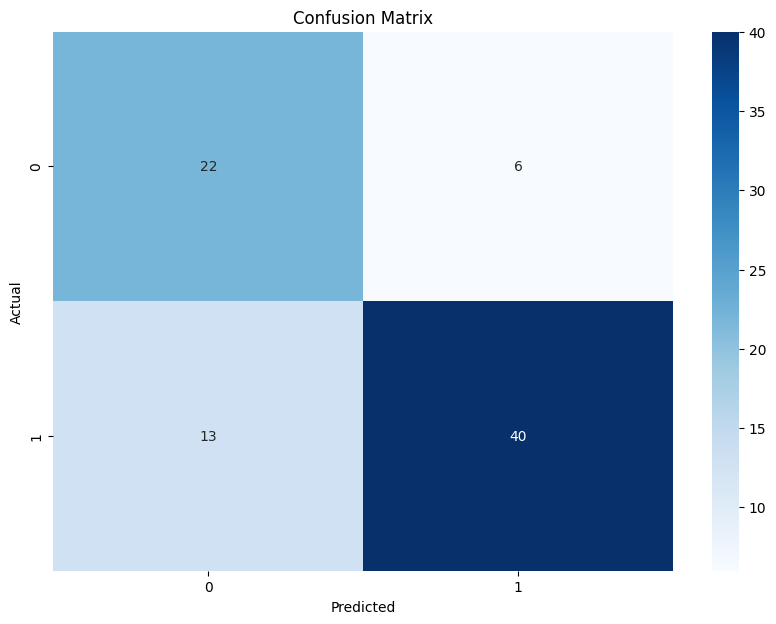

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
predict = model1.predict(xtest)
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")
# Evaluate the model on the test set
# predict = best_model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

AUC: 0.86


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


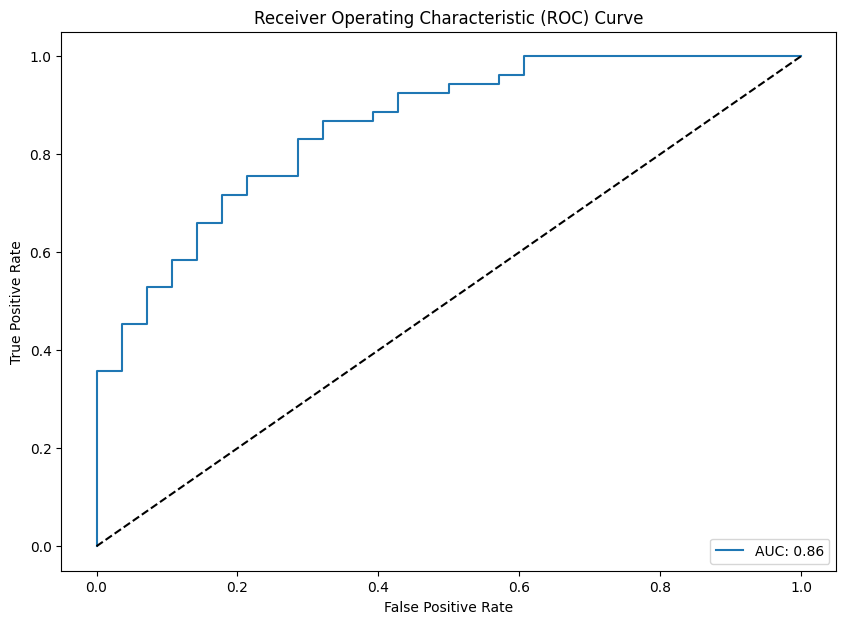

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model1.predict_proba(xtest)[:, 1]  # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [ ]:
import joblib

# Save the model using joblib
joblib.dump(model1, '/content/drive/MyDrive/Kaggle Logisitic Regression.joblib')

['/content/drive/MyDrive/Kaggle Logisitic Regression.joblib']

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Define the logistic regression model
model2 = KNeighborsClassifier(n_neighbors = 6)
model2.fit(augmented_data_combined, augmented_labels_combined)

KNeighborsClassifier(n_neighbors=6)

Training Accuracy: 67.90%
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.46      0.50        28
           1       0.74      0.79      0.76        53

    accuracy                           0.68        81
   macro avg       0.64      0.63      0.63        81
weighted avg       0.67      0.68      0.67        81



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix')

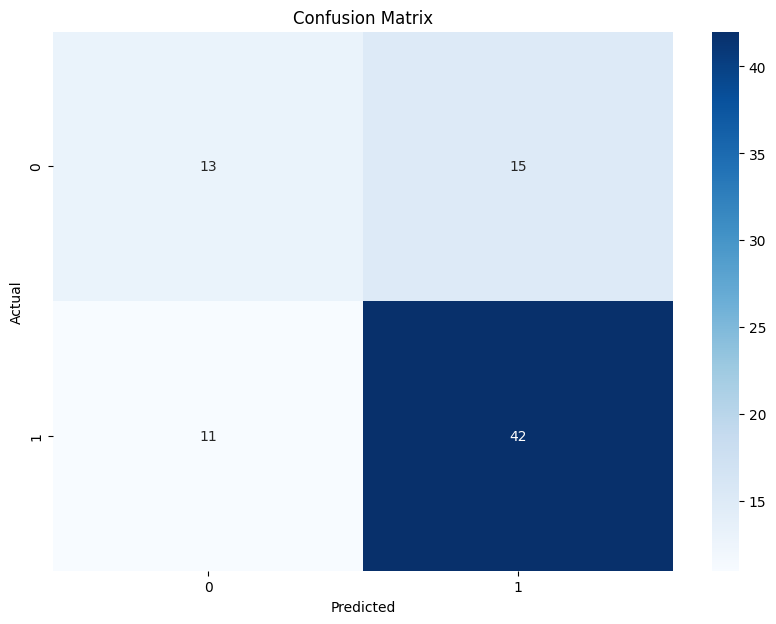

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
predict = model2.predict(xtest)
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")
# Evaluate the model on the test set
# predict = best_model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

AUC: 0.69


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


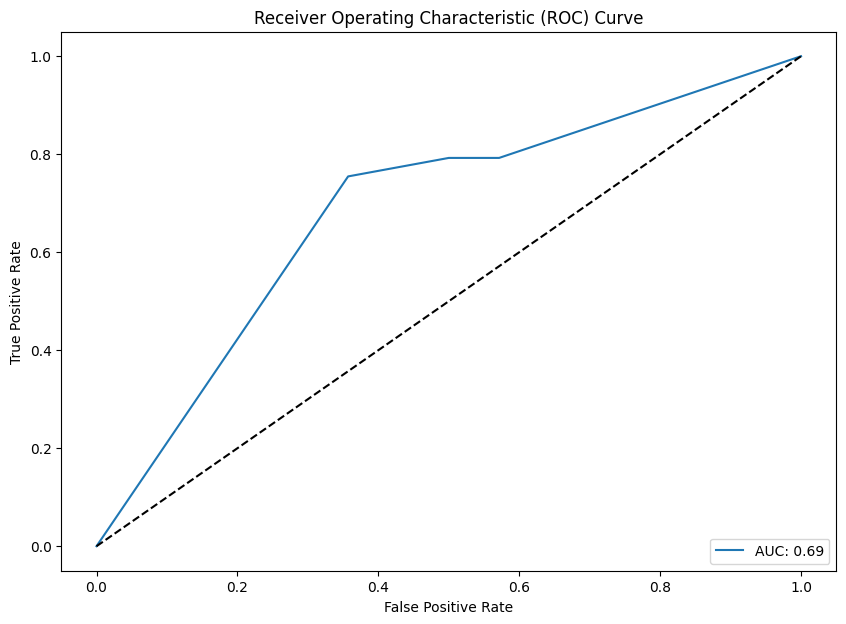

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model2.predict_proba(xtest)[:, 1]  # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [ ]:
# Define the logistic regression model
from sklearn.tree import DecisionTreeClassifier

model3 = DecisionTreeClassifier(max_depth = 4,min_samples_split = 2,max_leaf_nodes = 2)
model3.fit(augmented_data_combined, augmented_labels_combined)

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=2)

Training Accuracy: 72.84%
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.86      0.69        28
           1       0.90      0.66      0.76        53

    accuracy                           0.73        81
   macro avg       0.73      0.76      0.72        81
weighted avg       0.78      0.73      0.73        81



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix')

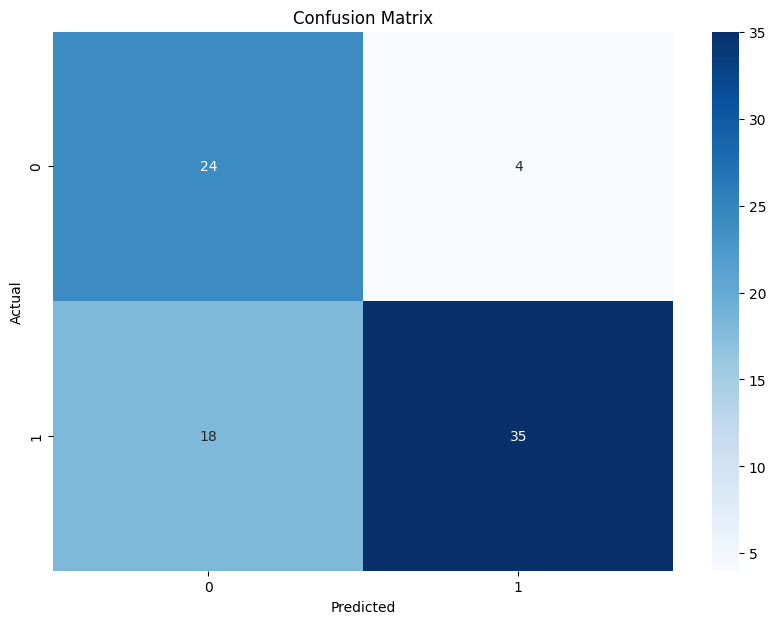

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
predict = model3.predict(xtest)
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")
# Evaluate the model on the test set
# predict = best_model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

AUC: 0.76


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


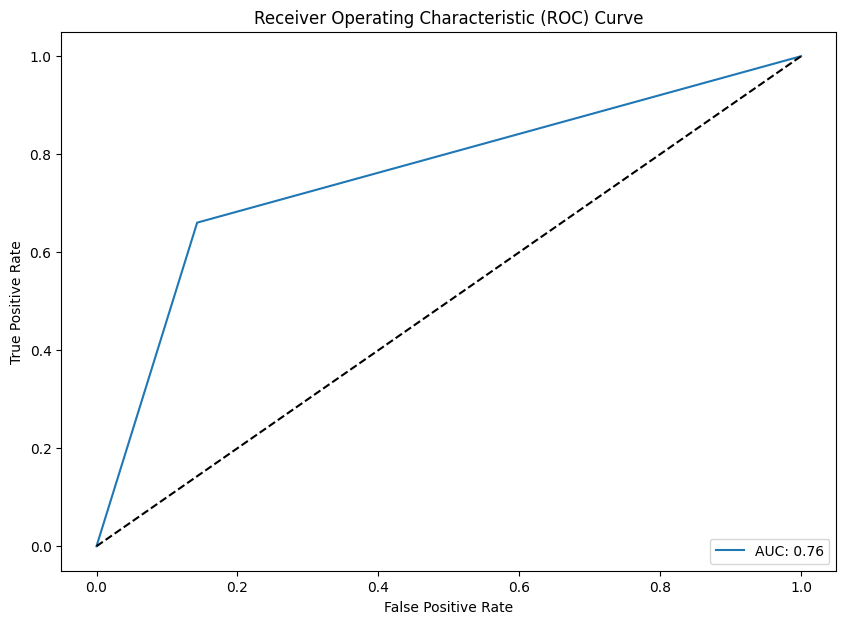

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model3.predict_proba(xtest)[:, 1]  # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [ ]:
# Define the logistic regression model
from sklearn.ensemble import RandomForestClassifier

model4 = RandomForestClassifier(max_depth = 5,n_estimators = 1000,criterion = 'gini')
model4.fit(augmented_data_combined, augmented_labels_combined)

RandomForestClassifier(max_depth=5, n_estimators=1000)

Training Accuracy: 69.14%
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.25      0.36        28
           1       0.70      0.92      0.80        53

    accuracy                           0.69        81
   macro avg       0.67      0.59      0.58        81
weighted avg       0.68      0.69      0.65        81



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix')

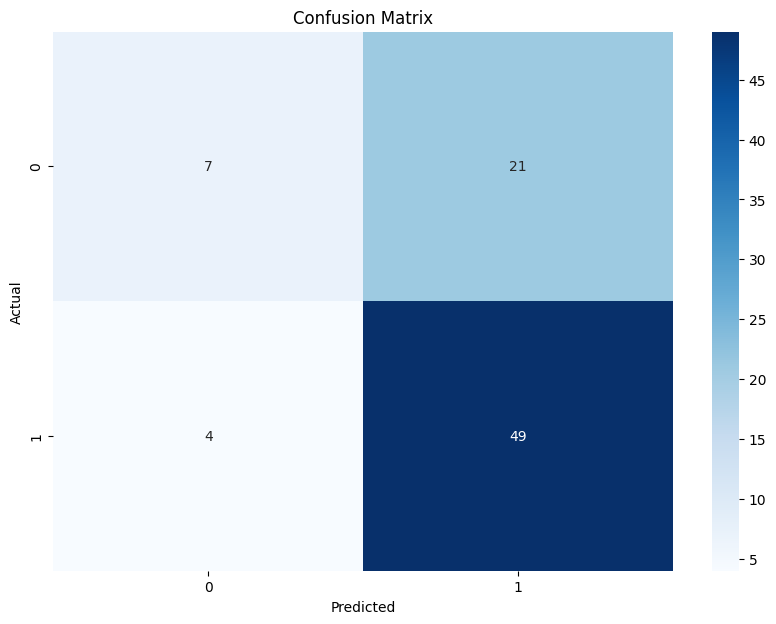

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
predict = model4.predict(xtest)
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")
# Evaluate the model on the test set
# predict = best_model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

AUC: 0.78


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


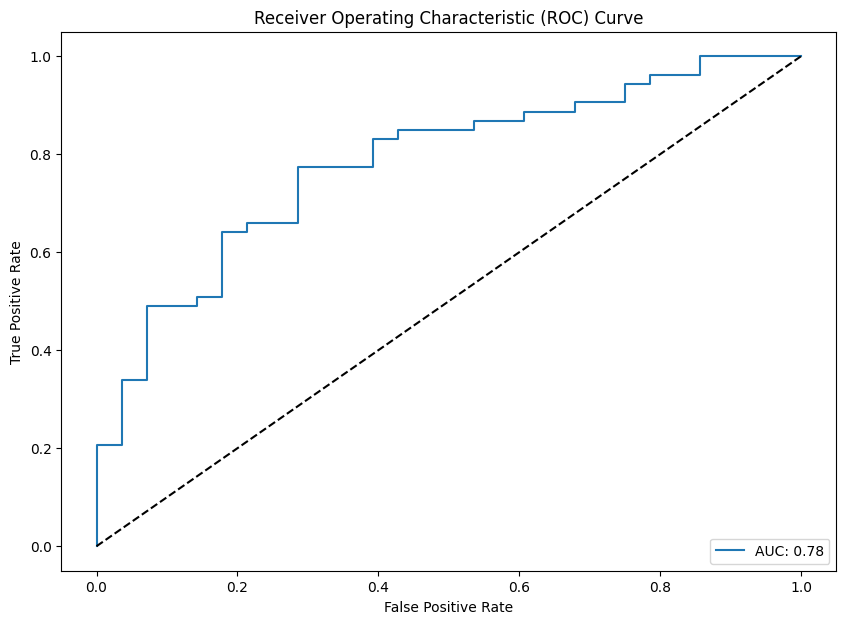

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model4.predict_proba(xtest)[:, 1]  # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [ ]:
# Define the logistic regression model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

model5 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 4,min_samples_split = 2,max_leaf_nodes = 2),n_estimators = 93)
model5.fit(augmented_data_combined, augmented_labels_combined)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    max_leaf_nodes=2),
                   n_estimators=93)

Training Accuracy: 72.84%
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.36      0.48        28
           1       0.73      0.92      0.82        53

    accuracy                           0.73        81
   macro avg       0.72      0.64      0.65        81
weighted avg       0.73      0.73      0.70        81



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix')

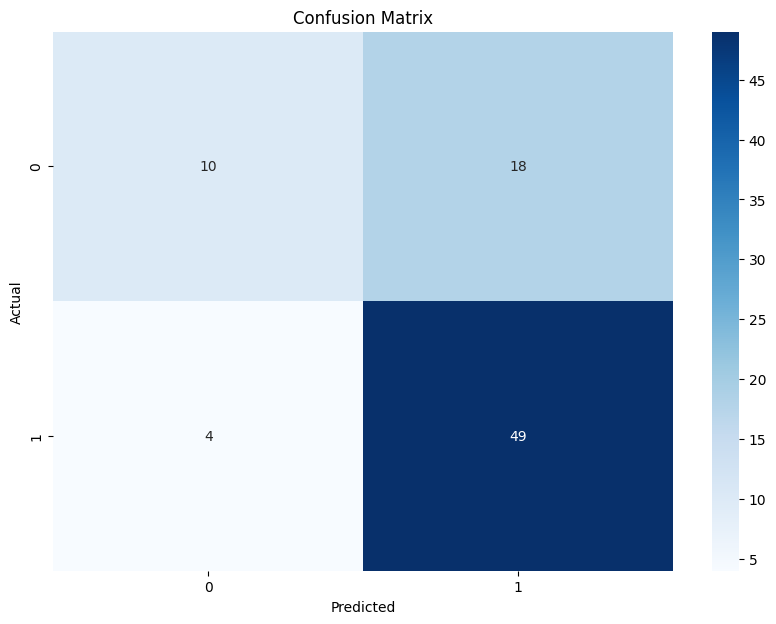

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
predict = model5.predict(xtest)
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")
# Evaluate the model on the test set
# predict = best_model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

AUC: 0.83


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


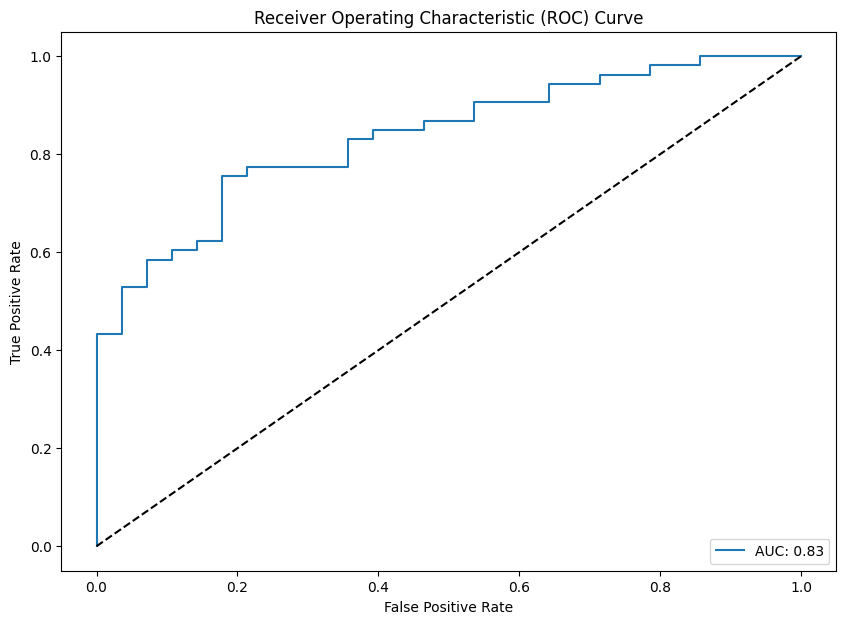

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model5.predict_proba(xtest)[:, 1]  # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score, log_loss
import math

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sigmoid = np.vectorize(sigmoid)

# Initialize StratifiedKFold with 10 splits
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Arrays to store cross-validation scores and losses
cv_score = []
cv_loss = []

# Perform Stratified K-Fold cross-validation for different numbers of PLS components
for i in range(1, 16):
    scores = []
    losses = []
    for train_index, test_index in skf.split(xtrain, ytrain):
        # Ensure the number of components does not exceed the rank upper bound
        n_components = min(i, xtrain[train_index].shape[0], xtrain[train_index].shape[1])
        lm = PLSRegression(n_components=n_components)
        lm.fit(xtrain[train_index], ytrain[train_index])
        y_pred_pls = lm.predict(xtrain[test_index])
        y_pred = np.array([1 if y > 0.5 else 0 for y in y_pred_pls])
        scores.append(accuracy_score(y_pred, ytrain[test_index]))
        losses.append(log_loss(ytrain[test_index], sigmoid(y_pred_pls)))
    cv_score.append(np.mean(scores))
    cv_loss.append(np.mean(losses))

# Print the cross-validation results
print("Cross-Validation Accuracy Scores for different PLS components:", cv_score)
print("Cross-Validation Log Loss for different PLS components:", cv_loss)

Cross-Validation Accuracy Scores for different PLS components: [0.8597222222222222, 0.8708333333333332, 0.8708333333333332, 0.8597222222222222, 0.8597222222222222, 0.8472222222222221, 0.8472222222222221, 0.8472222222222221, 0.8472222222222221, 0.8472222222222221, 0.8472222222222221, 0.8472222222222221, 0.8472222222222221, 0.8472222222222221, 0.8472222222222221]
Cross-Validation Log Loss for different PLS components: [0.4941322796555303, 0.4879406953665083, 0.4864029078727505, 0.485375034427717, 0.4847100740261432, 0.48474218643648764, 0.4844900862168576, 0.4846756156162638, 0.48466227053208727, 0.48468274293326025, 0.48469541018812884, 0.48469541018812884, 0.48469541018812884, 0.48469541018812884, 0.48469541018812884]


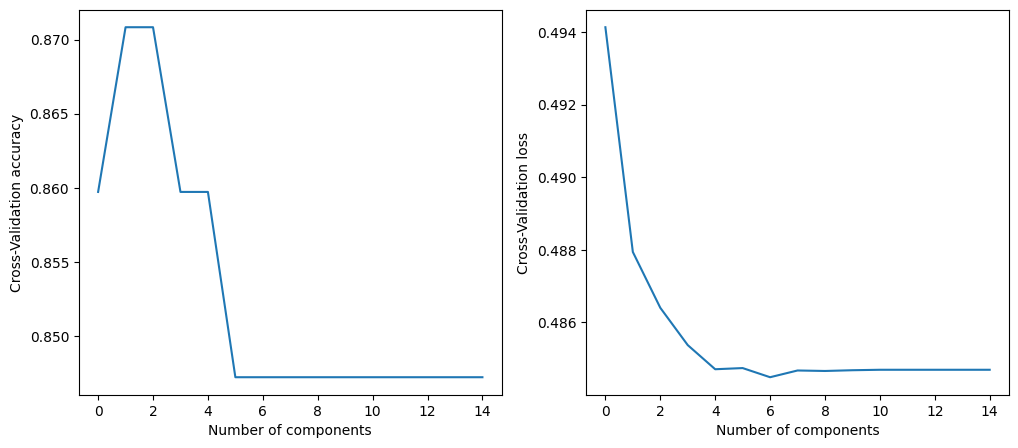

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(cv_score)
ax[1].plot(cv_loss)
ax[0].set_xlabel('Number of components')
ax[0].set_ylabel('Cross-Validation accuracy')
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Cross-Validation loss');

In [ ]:
model6 = PLSRegression(n_components=4)
model6.fit(augmented_data_combined, augmented_labels_combined)
y_pred_pls = lm.predict(xtest)
y_pred = np.array([1 if y > 0.5 else 0 for y in y_pred_pls])
accuracy_score(y_pred, ytest)

0.7530864197530864

AUC: 0.82


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PLSRegression was fitted with feature names
  warnings.warn(


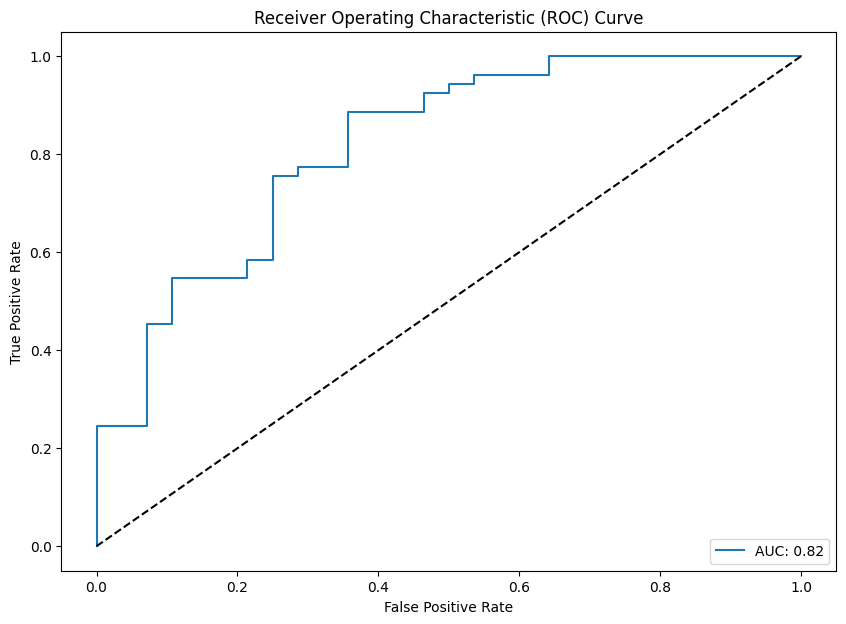

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model6.predict(xtest) # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [ ]:
from sklearn.svm import SVC
model7 = SVC(kernel='linear', probability =True)
model7.fit(augmented_data_combined, augmented_labels_combined)

SVC(kernel='linear', probability=True)

Training Accuracy: 75.31%
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.82      0.70        28
           1       0.88      0.72      0.79        53

    accuracy                           0.75        81
   macro avg       0.74      0.77      0.74        81
weighted avg       0.79      0.75      0.76        81



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix')

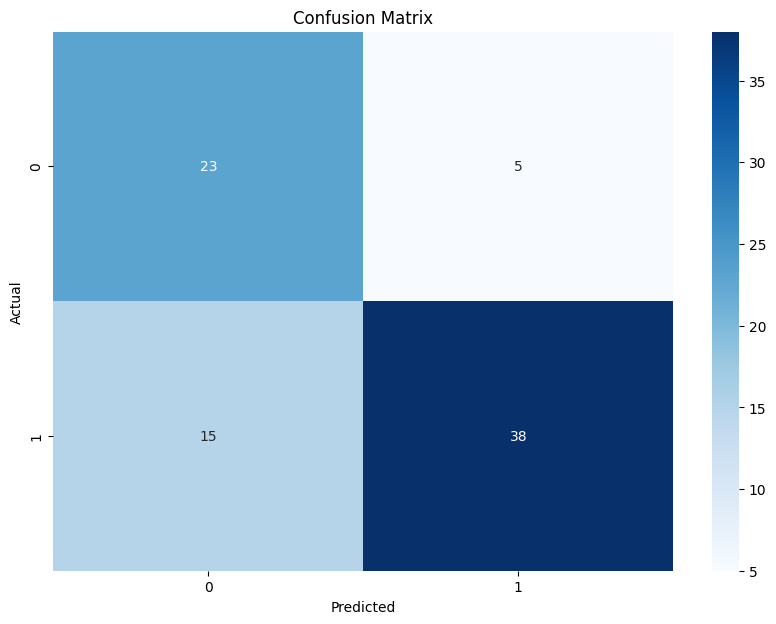

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
predict = model7.predict(xtest)
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")
# Evaluate the model on the test set
# predict = best_model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

AUC: 0.85


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


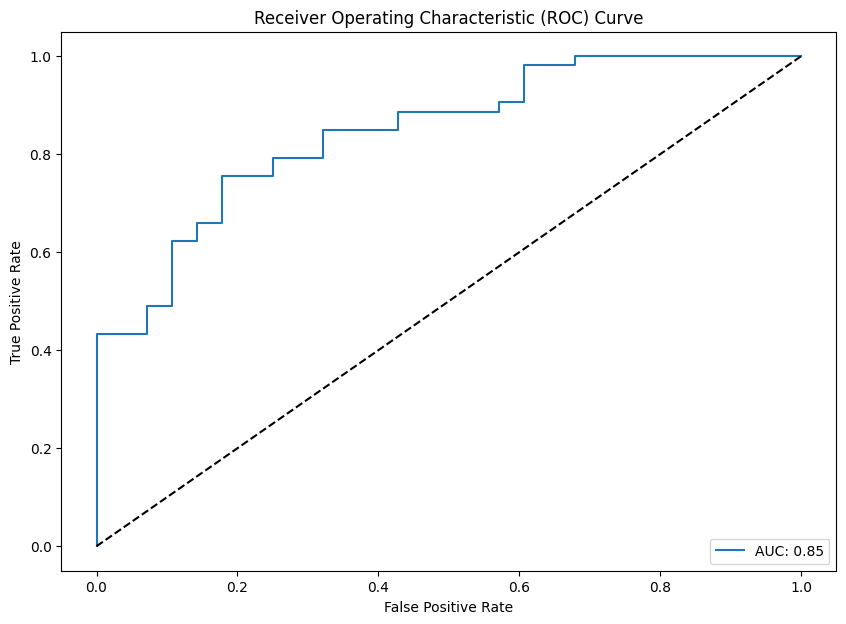

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model7.predict_proba(xtest)[:, 1]  # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [ ]:
# import joblib

# Save the model using joblib
joblib.dump(model7, '/content/drive/MyDrive/Kaggle SVC.joblib')

['/content/drive/MyDrive/Kaggle SVC.joblib']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

model8 = XGBClassifier()
model8.fit(augmented_data_combined, augmented_labels_combined)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Training Accuracy: 75.31%
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.57      0.62        28
           1       0.79      0.85      0.82        53

    accuracy                           0.75        81
   macro avg       0.73      0.71      0.72        81
weighted avg       0.75      0.75      0.75        81



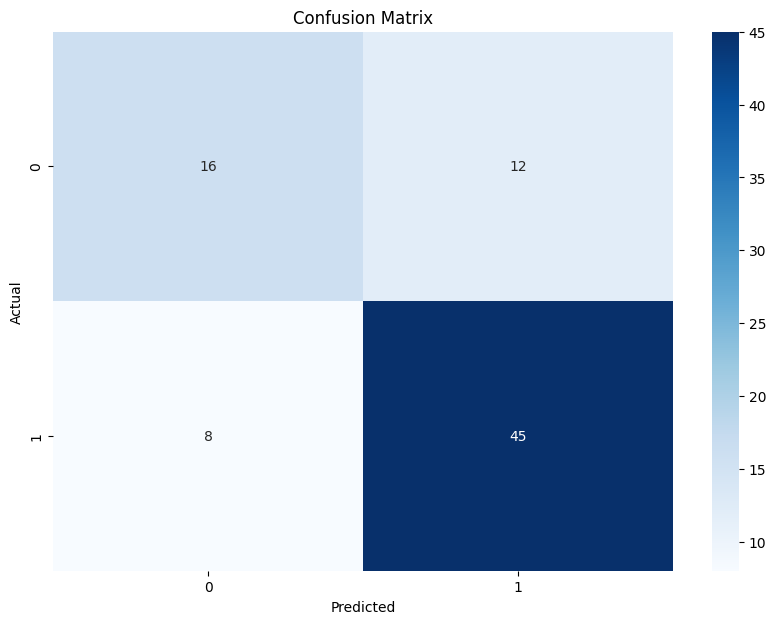

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
# predict = model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")
# Evaluate the model on the test set
predict = model8.predict(xtest)
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# plt.savefig("/content/drive/MyDrive/Kaggle Result.png")
plt.show()

AUC: 0.80


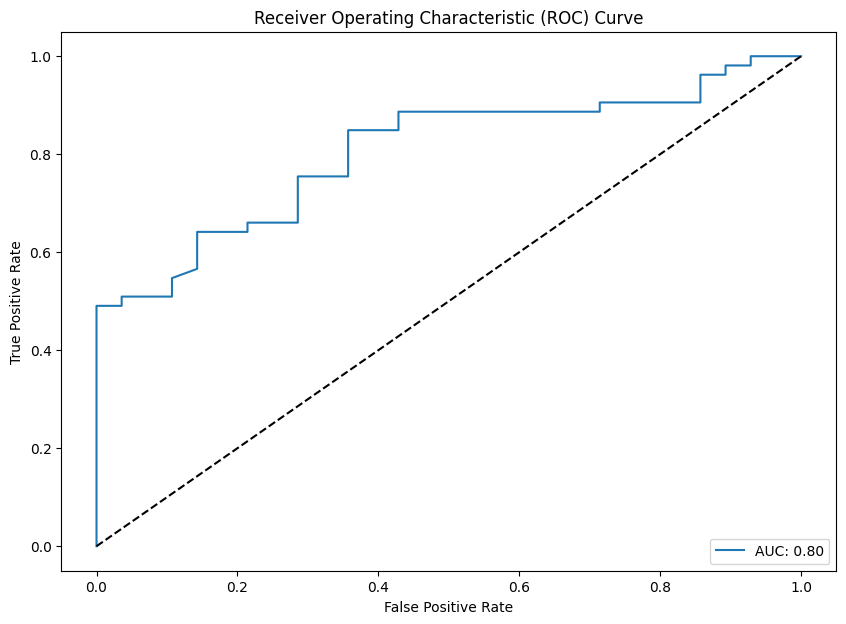

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model8.predict_proba(xtest)[:, 1]  # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# plt.savefig("/content/drive/MyDrive/Kaggle ROC Curve.png")
plt.show()

In [ ]:
from sklearn.ensemble import VotingClassifier

# Assuming model1, model2, and model3 are already defined and trained

# Create a VotingClassifier ensemble
voting_clf = VotingClassifier(estimators=[
    ('model1', model1),
    ('model5', model5),
    ('model7', model7)
], voting='hard')  # Use 'soft' for averaging probabilities

# Train the ensemble model
voting_clf.fit(augmented_data_combined, augmented_labels_combined)


VotingClassifier(estimators=[('model1', LogisticRegression()),
                             ('model5',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                                                  max_leaf_nodes=2),
                                                 n_estimators=93)),
                             ('model7',
                              SVC(kernel='linear', probability=True))])

In [ ]:
# Evaluate the ensemble model
ensemble_accuracy = voting_clf.score(xtest, ytest)
print(f"Ensemble Test Accuracy: {ensemble_accuracy * 100:.2f}%")

Ensemble Test Accuracy: 76.54%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [ ]:
# import joblib

# Save the model using joblib
model = model1
model_save_path = '/content/drive/MyDrive/Kaggle model.joblib'
joblib.dump(model, model_save_path)

['/content/drive/MyDrive/Kaggle model.joblib']

In [ ]:
# Load the model using joblib
model_save_path = '/content/drive/MyDrive/Kaggle model.joblib'
model = joblib.load(model_save_path)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Training Accuracy: 76.54%
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.79      0.70        28
           1       0.87      0.75      0.81        53

    accuracy                           0.77        81
   macro avg       0.75      0.77      0.75        81
weighted avg       0.79      0.77      0.77        81



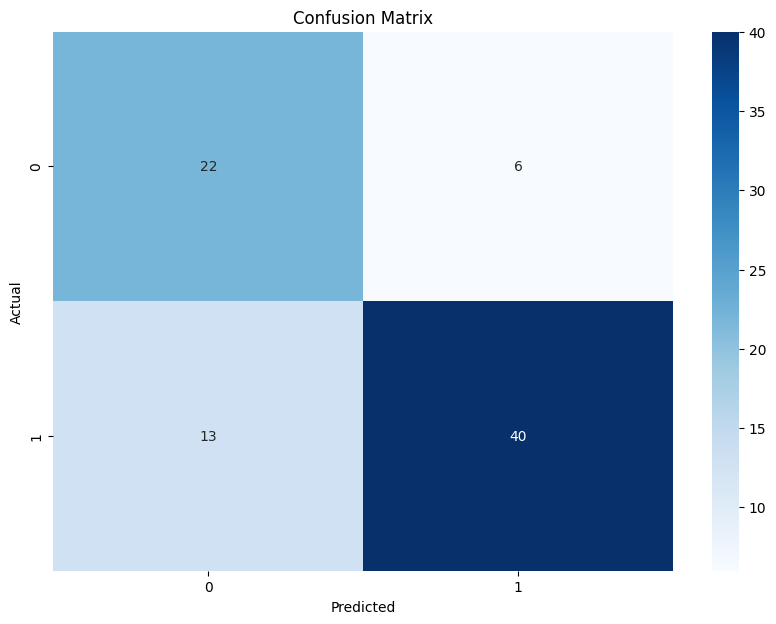

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
# predict = model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")
# Evaluate the model on the test set
predict = model.predict(xtest)
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.savefig("/content/drive/MyDrive/Kaggle Result.png")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


AUC: 0.86


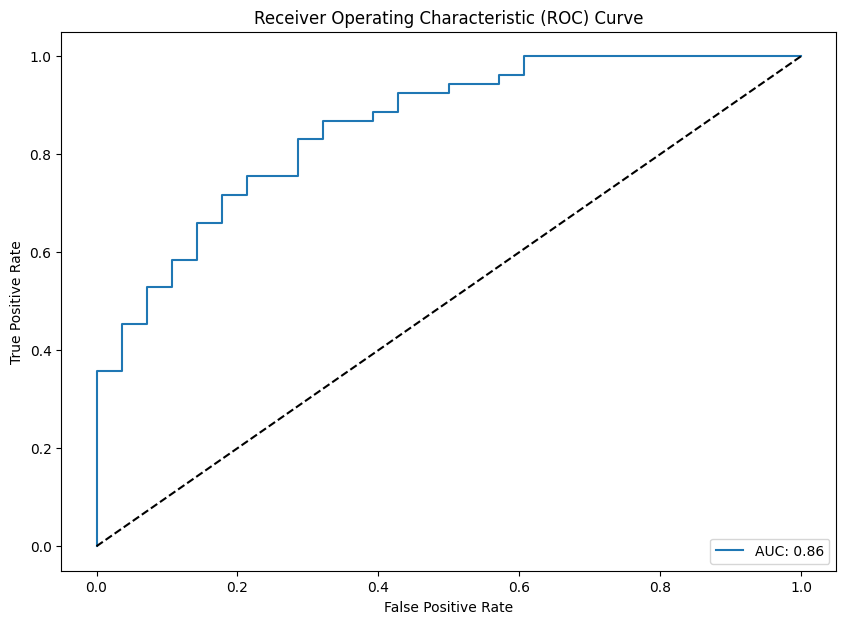

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model.predict_proba(xtest)[:, 1]  # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.savefig("/content/drive/MyDrive/Kaggle ROC Curve.png")
plt.show()

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 37.9 MB/s eta 0:00:00


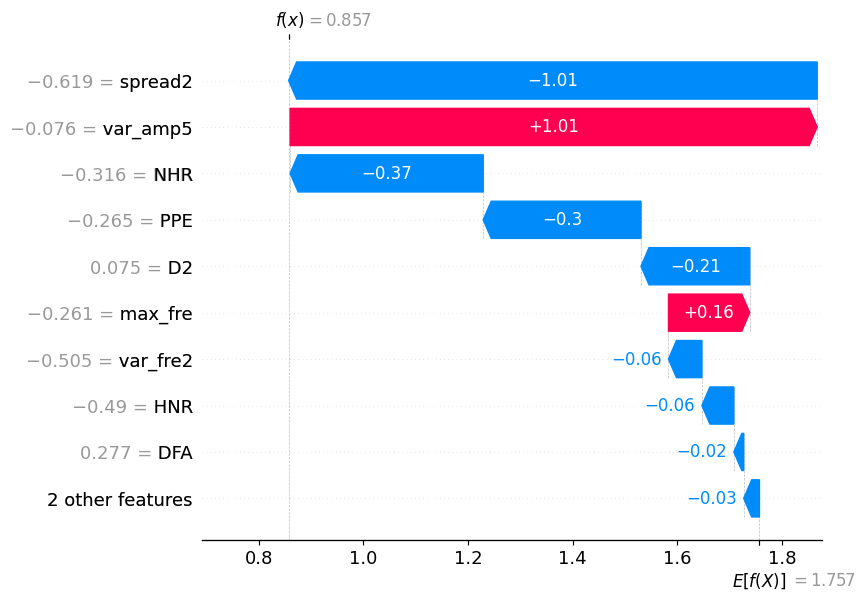

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap
import matplotlib.pyplot as plt

# Ensure that the model and training data (xtrain) are defined
selected_columns = ['max_fre', 'min_fre', 'var_fre2', 'var_amp5','NHR', 'HNR', 'RPDE', 'D2', 'DFA','spread2','PPE']

# Create a SHAP explainer
explainer = shap.Explainer(model, xtrain, feature_names= selected_columns)  # assuming 'status' is the last column

# Calculate SHAP values
shap_values = explainer(xtest)

# Plot summary plot
# shap.summary_plot(shap_values, xtest, feature_names=selected_columns, plot_type="bar")

# Plot detailed SHAP values for a single prediction
shap.initjs()

shap.plots.waterfall(shap_values[0])

# Save the plot as a PNG file
# plt.savefig("/content/drive/MyDrive/Kaggle SHAP.png")

# shap.force_plot(shap_values[0])
# shap.force_plot(explainer.expected_value, shap_values[0,:], xtest[0], feature_names=selected_columns)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Extract the features
selected_columns = ['max_fre', 'min_fre', 'var_fre1', 'var_amp1','NHR', 'HNR', 'RPDE', 'D2', 'DFA', 'spread2', 'PPE']

features = df[selected_columns].values

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

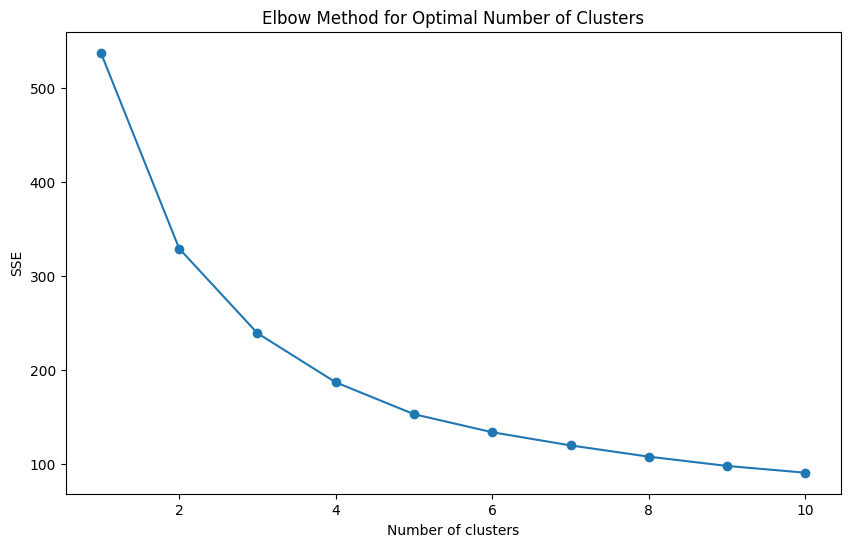

In [ ]:
# Elbow method to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(features_scaled)

# Add cluster labels to the original dataframe
df['kmeans_cluster'] = kmeans_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Draw the pairplot
selected_columns = ['max_fre', 'min_fre', 'var_fre1', 'var_amp1', 'NHR', 'HNR', 'RPDE', 'D2', 'DFA', 'spread2', 'PPE']

sns.pairplot(df, hue='kmeans_cluster', vars=selected_columns, palette='viridis')
plt.suptitle('Pairplot of Features Colored by KMeans Clusters', y=1.02)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with cluster labels and selected_columns as features
selected_columns = ['max_fre', 'min_fre', 'var_fre2', 'var_amp5','NHR', 'HNR', 'RPDE', 'D2', 'DFA','spread2','PPE']

# Calculate mean and standard deviation for each feature within each cluster
cluster_stats = df.groupby('kmeans_cluster')[selected_columns].agg(['mean', 'std'])
print(cluster_stats)

# Calculate Cohen's d for each feature
def cohen_d(x, y):
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x) ** 2 + np.std(y) ** 2) / 2)

cohen_d_values = {feature: cohen_d(df[df['kmeans_cluster'] == 0][feature], df[df['kmeans_cluster'] == 1][feature]) for feature in selected_columns}

# Print Cohen's d values
print("Cohen's d values for each feature:")
for feature, d_value in cohen_d_values.items():
    print(f"{feature}: {d_value:.2f}")

# Visualize with Boxplots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_columns, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='kmeans_cluster', y=feature, data=df, palette='viridis')
    plt.title(f"{feature} (Cohen's d: {cohen_d_values[feature]:.2f})")

plt.tight_layout()
plt.suptitle('Boxplots of Features by KMeans Clusters with Cohen\'s d Values', y=1.02)
plt.show()

KeyError: 'kmeans_cluster'

Cohen's d values for each feature:
max_fre: 0.76
min_fre: 0.98
var_fre2: -1.19
var_amp5: -1.24
NHR: -0.79
HNR: 0.92
RPDE: -0.72
D2: -0.74
DFA: -0.55
spread2: -1.07
PPE: -1.59


<ipython-input-239-778fa2d70d2d>:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['status'] == 0][feature], shade=True, label='status = 0', color='blue')
<ipython-input-239-778fa2d70d2d>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['status'] == 1][feature], shade=True, label='status = 1', color='orange')
<ipython-input-239-778fa2d70d2d>:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['status'] == 0][feature], shade=True, label='status = 0', color='blue')
<ipython-input-239-778fa2d70d2d>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an er

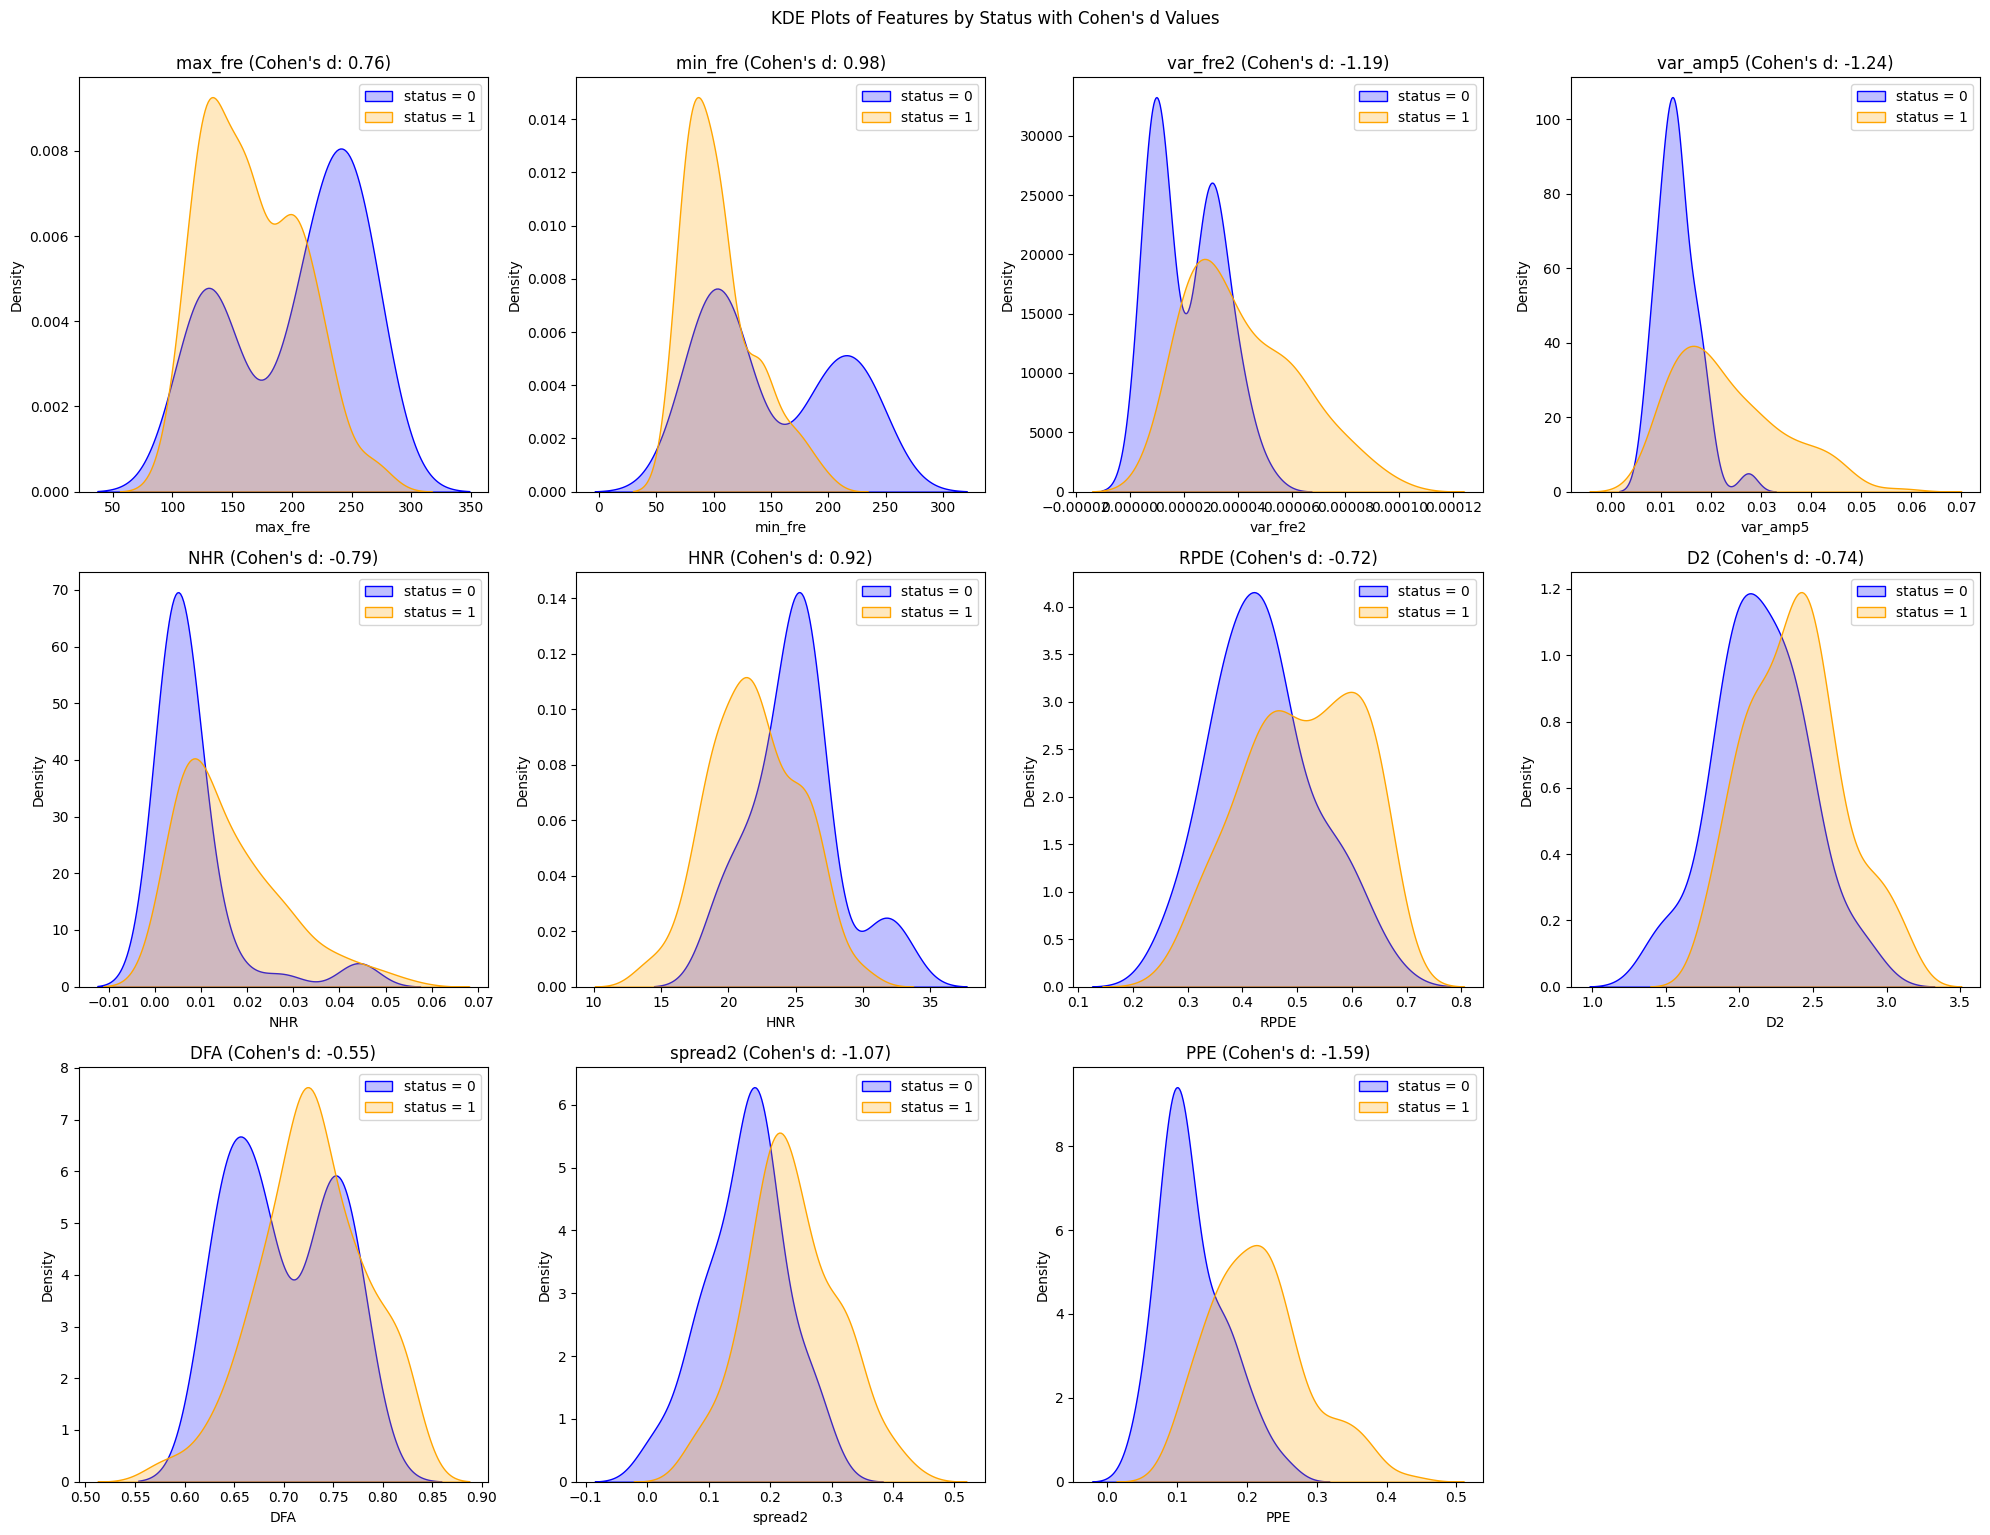

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with cluster labels and selected_columns as features
selected_columns =  ['max_fre', 'min_fre', 'var_fre2', 'var_amp5','NHR', 'HNR', 'RPDE', 'D2', 'DFA','spread2','PPE']

# Calculate Cohen's d for each feature
def cohen_d(x, y):
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2)

cohen_d_values = {feature: cohen_d(df[df['status'] == 0][feature], df[df['status'] == 1][feature]) for feature in selected_columns}

# Print Cohen's d values
print("Cohen's d values for each feature:")
for feature, d_value in cohen_d_values.items():
    print(f"{feature}: {d_value:.2f}")

# Visualize with KDE plots
plt.figure(figsize=(20, 15))
for i, feature in enumerate(selected_columns, 1):
    plt.subplot(3,4, i)
    sns.kdeplot(df[df['status'] == 0][feature], shade=True, label='status = 0', color='blue')
    sns.kdeplot(df[df['status'] == 1][feature], shade=True, label='status = 1', color='orange')
    plt.title(f"{feature} (Cohen's d: {cohen_d_values[feature]:.2f})")
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.suptitle('KDE Plots of Features by Status with Cohen\'s d Values', y=1.02)

plt.savefig("/content/drive/MyDrive/Kaggle EDA.png")
plt.show()

Cohen's d values for each feature:
max_fre: 0.76
min_fre: 0.98
var_fre2: -1.19
var_amp5: -1.24
NHR: -0.79
HNR: 0.92
RPDE: -0.72
D2: -0.74
DFA: -0.55
spread2: -1.07
PPE: -1.59


<ipython-input-240-c3a18c0085df>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y=feature, data=df, palette=['blue', 'orange'])
<ipython-input-240-c3a18c0085df>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y=feature, data=df, palette=['blue', 'orange'])
<ipython-input-240-c3a18c0085df>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y=feature, data=df, palette=['blue', 'orange'])
<ipython-input-240-c3a18c0085df>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will

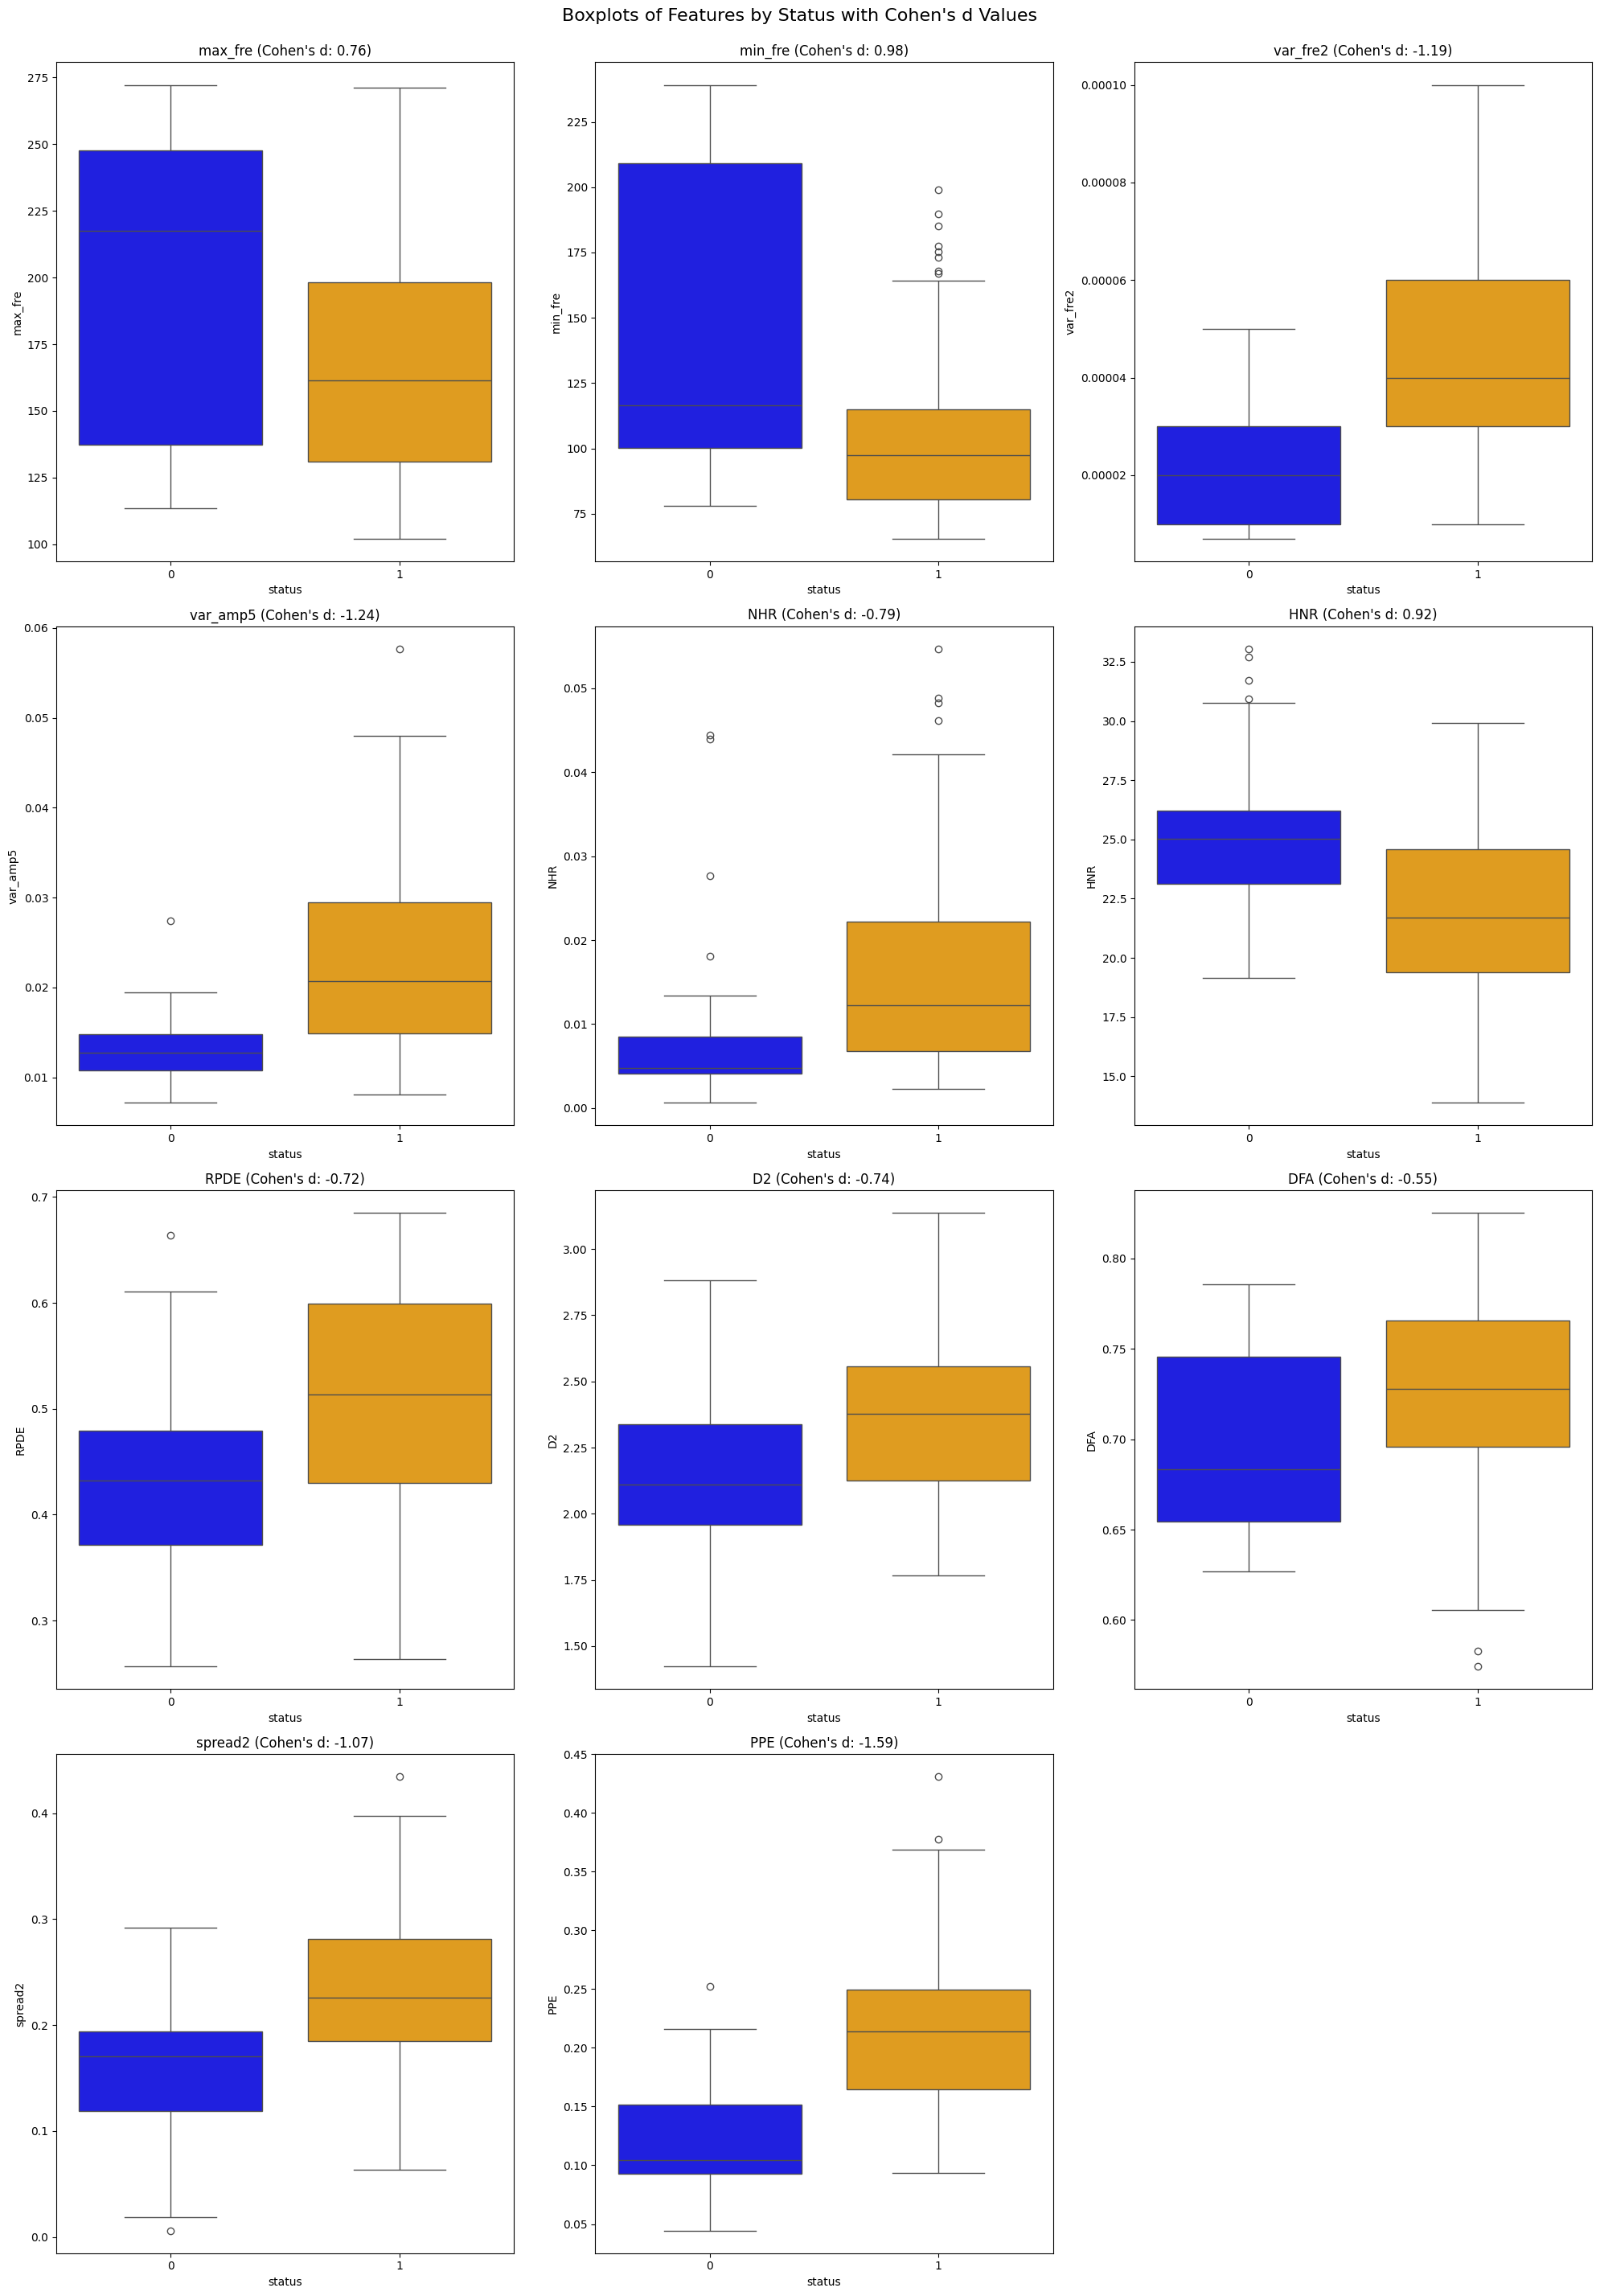

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with cluster labels and selected_columns as features
selected_columns =  ['max_fre', 'min_fre', 'var_fre2', 'var_amp5','NHR', 'HNR', 'RPDE', 'D2', 'DFA','spread2','PPE']

# Calculate Cohen's d for each feature
def cohen_d(x, y):
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2)

cohen_d_values = {feature: cohen_d(df[df['status'] == 0][feature], df[df['status'] == 1][feature]) for feature in selected_columns}

# Print Cohen's d values
print("Cohen's d values for each feature:")
for feature, d_value in cohen_d_values.items():
    print(f"{feature}: {d_value:.2f}")

# Visualize with KDE plots and Boxplots
plt.figure(figsize=(20, 30))

for i, feature in enumerate(selected_columns, 1):
    # Boxplot
    plt.subplot(4, 3, i)
    sns.boxplot(x='status', y=feature, data=df, palette=['blue', 'orange'])
    plt.title(f"{feature} (Cohen's d: {cohen_d_values[feature]:.2f})")
    plt.xlabel('status')
    plt.ylabel(feature)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.suptitle('Boxplots of Features by Status with Cohen\'s d Values', fontsize=16)

# Save the plot as a PNG file
plt.savefig("/content/drive/MyDrive/Kaggle EDA 2.png")
plt.show()

K-means Silhouette Score: 0.32448809028837455
Adjusted Rand Index for K-means: 0.11718656024095102
Normalized Mutual Information for K-means: 0.09433856773474983


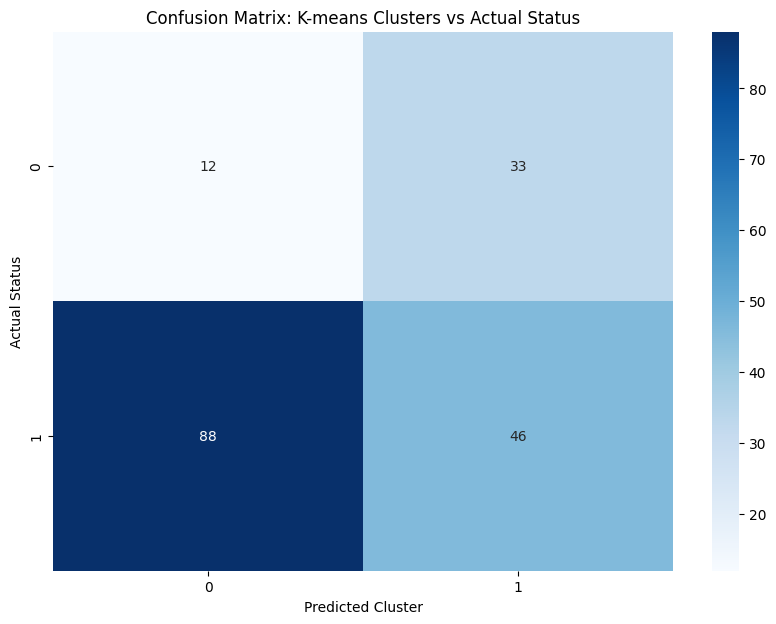

In [ ]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

# Silhouette score for K-means
kmeans_silhouette = silhouette_score(features_scaled, kmeans_labels)
print(f'K-means Silhouette Score: {kmeans_silhouette}')

# Adjusted Rand Index
ari_kmeans = adjusted_rand_score(df['status'], df['kmeans_cluster'])
print(f'Adjusted Rand Index for K-means: {ari_kmeans}')

# Normalized Mutual Information
nmi_kmeans = normalized_mutual_info_score(df['status'], df['kmeans_cluster'])
print(f'Normalized Mutual Information for K-means: {nmi_kmeans}')

# Confusion matrix
conf_matrix = confusion_matrix(df['status'], df['kmeans_cluster'])

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Cluster')
plt.ylabel('Actual Status')
plt.title('Confusion Matrix: K-means Clusters vs Actual Status')
plt.show()